In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Study/DL main project

/content/drive/MyDrive/Study/DL main project


# **Import Lib**

In [3]:
import numpy as np
import pandas as pd
from tensorflow.image import ssim
from process_data import ProcessData, DataGenerator
import os
from xray_abnormal_viewer import XABViewer
from dae_model import DAE_Model
from model_helper import Model_Args
from classifier_model import Classifier
import cv2
from keras.models import  load_model
from tensorflow.image import ssim
import matplotlib.pyplot as plt
from tqdm import tqdm

# **Load Data**

In [4]:
csv_path = './csv'
img_load_dir = './train/png'
npy_load_dir = './train/npy'
mask_load_dir = './train/mask'
lung_load_dir = './train/lung'
noise_load_dir = './train/noise'

# batch_14 = ['000','001']
batch_14 = ['{:03d}'.format(i) for i in range(21)]
# make process variable
pdata = ProcessData(seed=42)

In [5]:
# npy_dict = {}
mask_dict = {}
img_dict = {}
lung_dict = {}
noise_dict = {}

for b in batch_14:
  batch_csv = os.path.join(csv_path,'14',b+'.csv')
  mask_load_path = os.path.join(mask_load_dir,'14',b)
  img_load_path = os.path.join(img_load_dir,'14',b)
  lung_load_path = os.path.join(lung_load_dir,'14',b)
  noise_load_path = os.path.join(noise_load_dir,'14',b)
  noise_dict[noise_load_path] = mask_dict[mask_load_path] = img_dict[img_load_path] = lung_dict[lung_load_path] = pdata.get_img_names(batch_csv)

In [6]:
img_paths = pdata.get_paths(img_dict,'.png')
mask_paths = pdata.get_paths(mask_dict,'.png')
lung_paths = pdata.get_paths(lung_dict,'.png')
noise_paths = pdata.get_paths(noise_dict,'.png')

In [7]:
def processor(x,y):
  noises = pdata.get_imgs(x,show_process=False)
  lungs = pdata.get_imgs(y,show_process=False)
  return noises, lungs

# **Evaluate Model**

## **Get data**

In [8]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest, mtrain, mtest = train_test_split(noise_paths,lung_paths,mask_paths,test_size=0.1,random_state=42)
xtrain,xval,ytrain,yval, mtrain, mval = train_test_split(xtrain,ytrain,mtrain,test_size=0.15,random_state=42)
xtrain.shape, xval.shape,xtest.shape

((2368,), (418,), (310,))

In [9]:
xtest = np.array(pdata.get_imgs(xtest))

In [10]:
ytest = np.array(pdata.get_imgs(ytest))

In [11]:
mtest = np.array(pdata.get_imgs(mtest))

## **Evaluate by Discriminator**

### Get data for Discriminator using autoencoder_c128x128x64x6_f32_64_64_ep200_relu

In [ ]:
ae_path = './model/checkpoint/autoencoder_c128x128x64x6_f32_64_64_ep200_relu/autoencoder_c128x128x64x6_f32_64_64_ep200_relu-0142-15.2921.h5'
autoencoder = load_model(ae_path,compile=False)

In [ ]:
xgen = autoencoder.predict(xtest,batch_size=5)

In [ ]:
nbtrue = len(ytest)
x = np.concatenate([xgen,ytest])
y = np.concatenate([np.full(nbtrue,0),np.full(nbtrue,1)])

In [ ]:
xdtrain, xdtest, ydtrain, ydtest = train_test_split(x,y,test_size=0.2,random_state=42)

In [ ]:
xdtrain, xdval, ydtrain, ydval = train_test_split(xdtrain,ydtrain,test_size=0.2,random_state=42)

In [ ]:
np.unique(ydtrain,return_counts=True)

(array([0, 1]), array([198, 198]))

In [ ]:
nbtrain = len(xdtrain)+len(xdval)
spep = nbtrain/5
nbtrain, spep

(496, 99.2)

### Evaluate by model descriminator v1

#### Train model

In [ ]:
args = Model_Args(
    input_shape=(1024,1024,1),
    filters=(32,64,128,512),
    latentDim=1,
    model_name='discriminator_v1',
    model_dir='./model')
model = Classifier(args)

In [ ]:
model.model.summary()

Model: "classifier_discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1024, 1024, 1)]   0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 512, 512, 32)      320       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 512, 512, 32)      0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 512, 512, 32)      128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 256, 256, 64)      18496     
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 256, 256, 64)      0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 256, 2

In [ ]:
ep = 20
bs = 5

In [ ]:
train_gen = DataGenerator(xdtrain,ydtrain,bs)
val_gen = DataGenerator(xdval,ydval,bs)

In [ ]:
model.fit(train_gen,val_gen,ep,bs)

Epoch 1/20
79/79 [==============================] - 373s 5s/step - loss: 0.5343 - auc: 0.4729 - lr: 9.9999e-04 - val_loss: 0.5298 - val_auc: 0.4770 - val_lr: 9.9997e-04

Epoch 00001: val_loss improved from inf to 0.52979, saving model to ./model/checkpoint/classifier_discriminator/classifier_discriminator-0001-0.5298.h5
Epoch 2/20
79/79 [==============================] - 369s 5s/step - loss: 0.5184 - auc: 0.5000 - lr: 9.9996e-04 - val_loss: 0.5100 - val_auc: 0.5000 - val_lr: 9.9994e-04

Epoch 00002: val_loss improved from 0.52979 to 0.51000, saving model to ./model/checkpoint/classifier_discriminator/classifier_discriminator-0002-0.5100.h5
Epoch 3/20
79/79 [==============================] - 369s 5s/step - loss: 0.4894 - auc: 0.5000 - lr: 9.9993e-04 - val_loss: 0.5100 - val_auc: 0.5000 - val_lr: 9.9990e-04

Epoch 00003: val_loss did not improve from 0.51000
Epoch 4/20
79/79 [==============================] - 371s 5s/step - loss: 0.5028 - auc: 0.5000 - lr: 9.9989e-04 - val_loss: 0.5100 -

In [ ]:
#model.plot_show()

6

In [ ]:
model.save()
# model_view = XABViewer(model.autoencoder,ytest[:10],xtest[:10])
# model_view.view_result(3,450)

#### View model

### Evaluate by model descriminator v2

#### Train model

In [ ]:
args = Model_Args(
    input_shape=(1024,1024,1),
    filters=(32,64,64),    
    latent_filters=(64,64,64,64,64),
    latentDim=1,
    model_name='discriminator_v2',
    model_dir='./model')
model2 = Classifier(args)

In [ ]:
from keras.metrics import AUC
model2.compile(metrics=[AUC()])

In [ ]:
model2.model.summary()

Model: "classifier_discriminator_v2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1024, 1024, 1)]   0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 512, 512, 32)      320       
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 512, 512, 32)      0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 512, 512, 32)      128       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 256, 256, 64)      18496     
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 256, 256, 64)      0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 256

In [ ]:
ep = 20
bs = 5

In [ ]:
train_gen = DataGenerator(xdtrain,ydtrain,bs)
val_gen = DataGenerator(xdval,ydval,bs)

In [ ]:
model2.fit(train_gen,val_gen,ep,bs)

Epoch 1/20
79/79 [==============================] - 432s 5s/step - loss: 0.4911 - auc_1: 0.4946 - lr: 9.9999e-04 - val_loss: 0.5100 - val_auc_1: 0.5000 - val_lr: 9.9997e-04

Epoch 00001: val_loss improved from inf to 0.51000, saving model to ./model/checkpoint/classifier_discriminator_v2/classifier_discriminator_v2-0001-0.5100.h5
Epoch 2/20
79/79 [==============================] - 434s 6s/step - loss: 0.5043 - auc_1: 0.4943 - lr: 9.9996e-04 - val_loss: 0.5100 - val_auc_1: 0.5000 - val_lr: 9.9994e-04

Epoch 00002: val_loss did not improve from 0.51000
Epoch 3/20
79/79 [==============================] - 430s 5s/step - loss: 0.4694 - auc_1: 0.5005 - lr: 9.9993e-04 - val_loss: 0.5100 - val_auc_1: 0.5000 - val_lr: 9.9990e-04

Epoch 00003: val_loss did not improve from 0.51000
Epoch 4/20
79/79 [==============================] - 431s 5s/step - loss: 0.5055 - auc_1: 0.5009 - lr: 9.9989e-04 - val_loss: 0.5100 - val_auc_1: 0.5000 - val_lr: 9.9987e-04

Epoch 00004: val_loss did not improve from 0

In [ ]:
#model.plot_show()

6

In [ ]:
model2.save()
# model_view = XABViewer(model.autoencoder,ytest[:10],xtest[:10])
# model_view.view_result(3,450)

#### View model

## **Evaluate lung generator by SNR - Signal to noise ratio**

### Evaluate model autoencoder_c128x128x64x6_f32_64_64_ep200_relu

#### Load model

In [ ]:
ae_path = './model/checkpoint/autoencoder_c128x128x64x6_f32_64_64_ep200_relu/autoencoder_c128x128x64x6_f32_64_64_ep200_relu-0142-15.2921.h5'
autoencoder = load_model(ae_path,compile=False)

#### Evaluate

In [ ]:
xgen = autoencoder.predict(xtest,batch_size=5)

In [ ]:
xgen = xgen*mtest

In [ ]:
from tqdm.auto import tqdm
def get_mean_ssim(xs,ys):
    '''
    params:
      xs,ys: danh sách hình cần được so sánh
    return:
      giá trị trung bình của độ tương đồng 2 danh sách
    '''
    nb = len(xs)
    ssims = []
    for i in tqdm(range(nb)):
      s = ssim(xs[i].astype(float),ys[i].astype(float),255)
      ssims.append(s.numpy())
    ssims = np.array(ssims)
    return ssims.sum()/nb

In [ ]:
eresult = get_mean_ssim(xgen,ytest)

In [ ]:
eresult

0.9573580834173387

In [ ]:
me = 1-eresult
df = pd.DataFrame({'mean':np.array([me]),'score':np.array([eresult])})
dfpath = ae_path.replace('.h5','_best_mean.csv')
df.to_csv(dfpath)

### Evaluate model autoencoder_c128x128x64x3_f32_64_64_ep200_relu

#### Load model

In [ ]:
ae_path = './model/checkpoint/autoencoder_c128x128x64x3_f32_64_64_ep200_relu/autoencoder_c128x128x64x3_f32_64_64_ep200_relu-0143-15.8944.h5'
autoencoder = load_model(ae_path,compile=False)

#### Evaluate

In [ ]:
xgen = autoencoder.predict(xtest,batch_size=5)

In [ ]:
xgen = xgen*mtest

In [ ]:
eresult = get_mean_ssim(xgen,ytest)

In [ ]:
eresult

0.9633818595640121

In [ ]:
me = 1-eresult
df = pd.DataFrame({'mean':np.array([me]),'score':np.array([eresult])})
dfpath = ae_path.replace('.h5','_best_mean.csv')
df.to_csv(dfpath)

## **Evaluate mask generator by IOU**

### **Get data for evaluate mask 256x256**

In [ ]:
# resize ytest
mytest = [np.expand_dims(cv2.resize(mt[:,:,0],(256,256)),axis=-1) for mt in mtest]
mytest = np.array(mytest)
mytest.shape

(310, 256, 256, 1)

In [ ]:
mxtest = pdata.get_data_noise_vlazy(mytest,ntype=1)

### Evaluate autoencoder_mask_i256x256_d256_f32x64x2_ep100_sigmoid

#### Load model

In [ ]:
ae_path = './model/checkpoint/autoencoder_mask_i256x256_d256_f32x64x2_ep100_sigmoid/autoencoder_mask_i256x256_d256_f32x64x2_ep100_sigmoid-0012-0.0195.h5'
autoencoder = load_model(ae_path,compile=False)

#### Evaluate

In [ ]:
mxgen = autoencoder.predict(mxtest,batch_size=5)

(310, 256, 256)


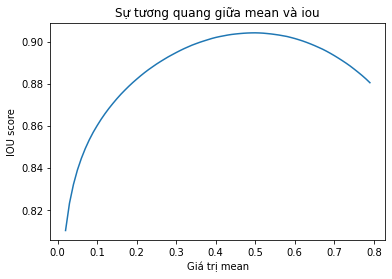

In [ ]:
mxmeans = np.arange(0.02,0.8,0.01)
mxblurs = np.array([cv2.blur(mxg,(5,5)) for mxg in mxgen])
print(mxblurs.shape)
scores = []
for mxmean in mxmeans:
  temp = mxblurs.copy()
  temp[temp < mxmean] = 0
  temp[temp >= mxmean] = 1  
  scores.append(pdata.iou_score(mytest[:,:,:,0],temp))
scores = np.array(scores)
plt.plot(mxmeans,scores)
plt.xlabel('Giá trị mean')
plt.ylabel('IOU score')
plt.title('Sự tương quang giữa mean và iou')
plt.show()

In [ ]:
df = pd.DataFrame({'mean': mxmeans,'score':scores})
dfpath = ae_path.replace('.h5','_best_mean.csv')
df.to_csv(dfpath)

In [ ]:
tindex = scores.argmax()
bmean = mxmeans[tindex]
print('best score: ',scores[tindex])
print('best mean: ',bmean)

best score:  0.9043370463084935
best mean:  0.49999999999999994


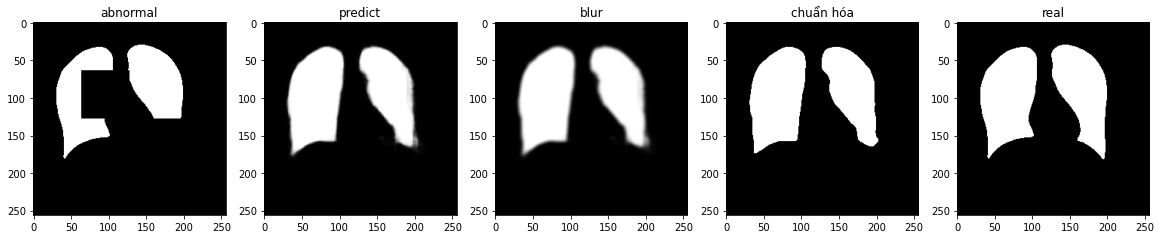

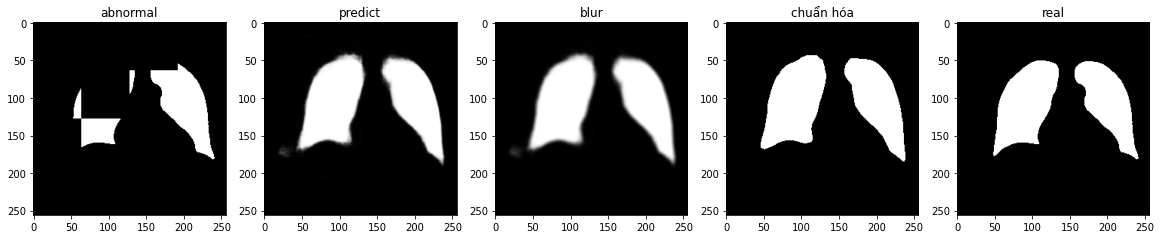

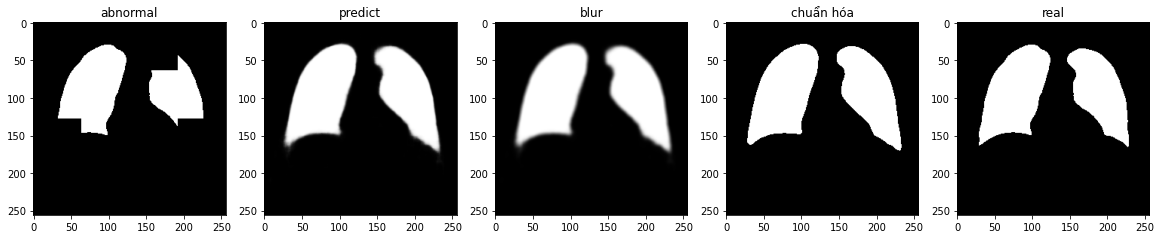

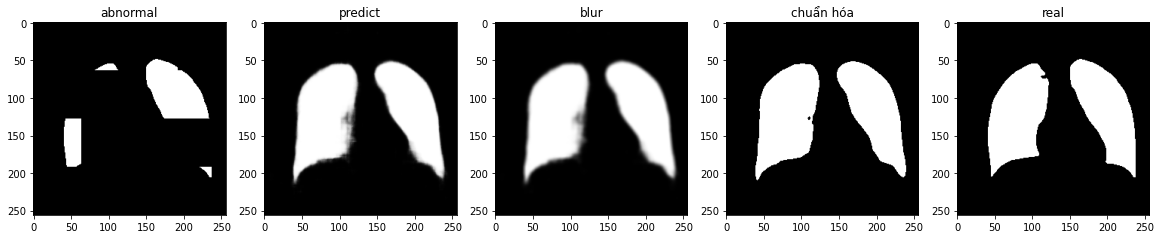

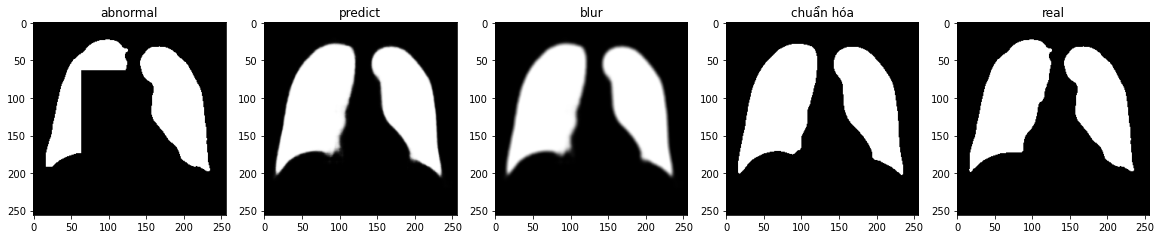

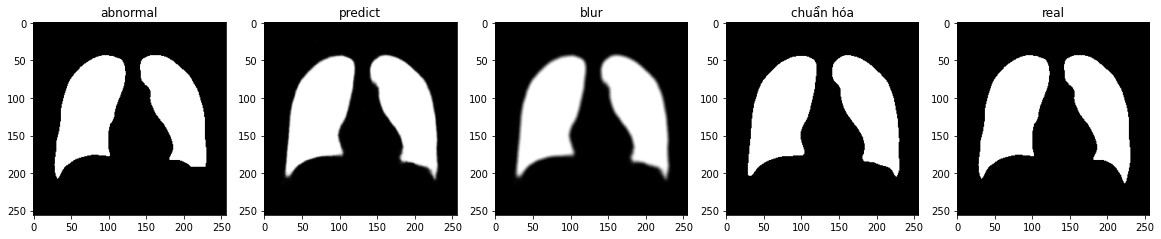

In [ ]:
rows = 1
cols = 5
for i in range(10):
  plt.figure(figsize=(20,10))
  plt.subplot(rows,cols,1)
  plt.imshow(mxtest[i,:,:,0],cmap='gray')
  plt.title('abnormal')
  plt.subplot(rows,cols,2)
  plt.imshow(mxgen[i,:,:,0],cmap='gray')
  plt.title('predict')
  plt.subplot(rows,cols,3)
  mxblur = mxblurs[i].copy()
  plt.imshow(mxblur,cmap='gray')
  plt.title('blur')
  plt.subplot(rows,cols,4)
  mxblur[mxblur < bmean] = 0
  mxblur[mxblur >= bmean] = 1
  plt.imshow(mxblur,cmap='gray')
  plt.title('chuẩn hóa')
  plt.subplot(rows,cols,5)
  plt.imshow(mytest[i,:,:,0],cmap='gray')
  plt.title('real')
  plt.show()

In [ ]:
mygen = autoencoder.predict(mytest,batch_size=5)

In [ ]:
myblurs = np.array([cv2.blur(myg,(5,5)) for myg in mygen])
mytemp = myblurs.copy()
mytemp[mytemp < bmean] = 0
mytemp[mytemp >= bmean] = 1
myscore = pdata.iou_score(mytest[:,:,:,0],mytemp)
print('Score với mask bình thường: ',myscore)

Score với mask bình thường:  0.9286645306485135


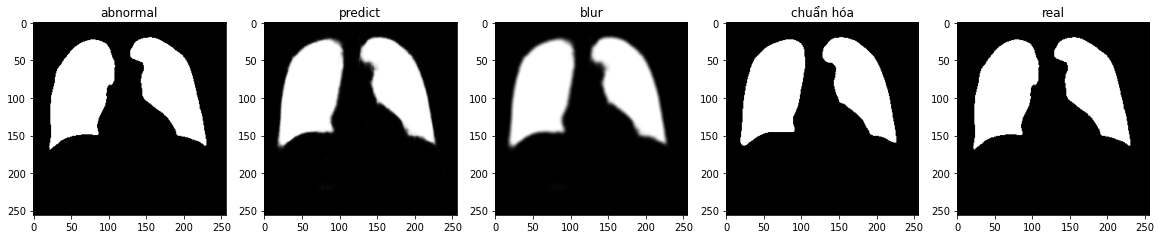

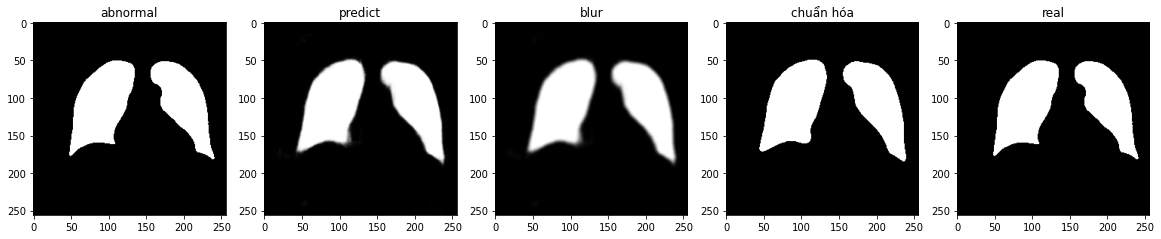

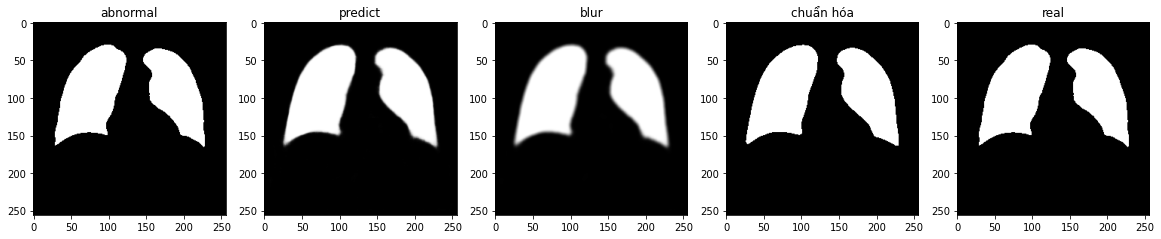

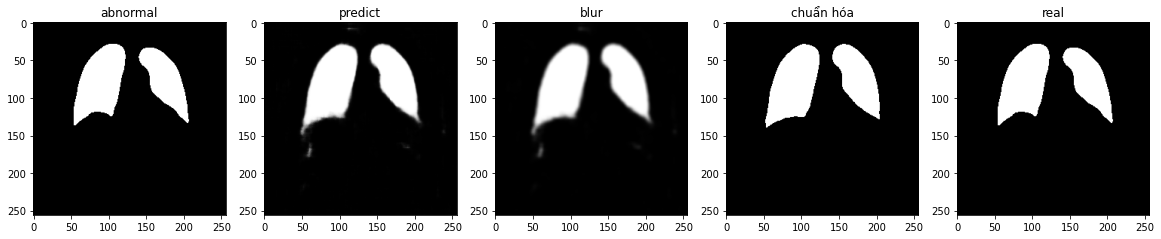

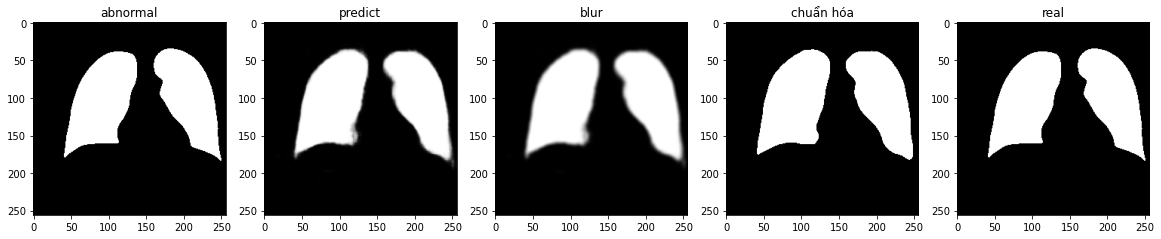

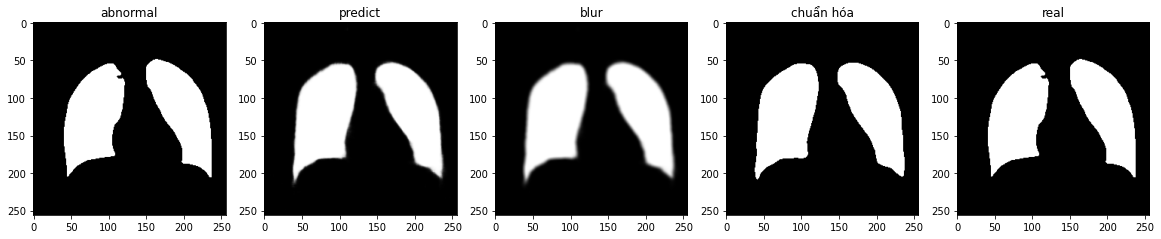

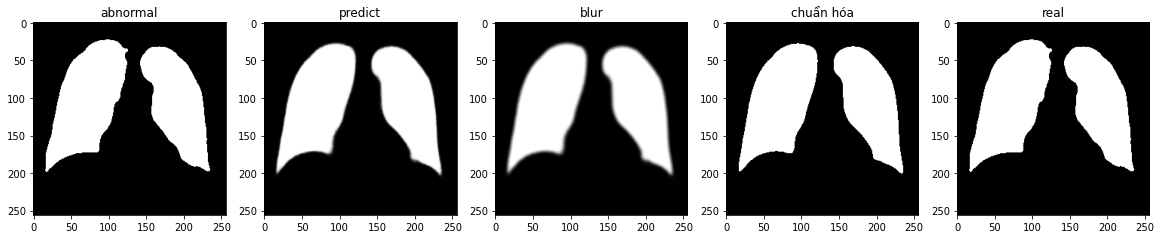

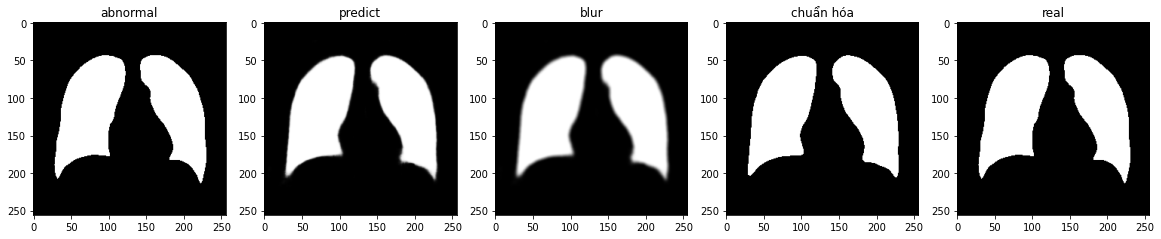

In [ ]:
rows = 1
cols = 5
for i in range(10):
  plt.figure(figsize=(20,10))
  plt.subplot(rows,cols,1)
  plt.imshow(mytest[i,:,:,0],cmap='gray')
  plt.title('abnormal')
  plt.subplot(rows,cols,2)
  plt.imshow(mygen[i,:,:,0],cmap='gray')
  plt.title('predict')
  plt.subplot(rows,cols,3)
  myblur = myblurs[i].copy()
  plt.imshow(myblur,cmap='gray')
  plt.title('blur')
  plt.subplot(rows,cols,4)
  myblur[myblur < bmean] = 0
  myblur[myblur >= bmean] = 1
  plt.imshow(myblur,cmap='gray')
  plt.title('chuẩn hóa')
  plt.subplot(rows,cols,5)
  plt.imshow(mytest[i,:,:,0],cmap='gray')
  plt.title('real')
  plt.show()

### Evaluate autoencoder_mask_i256x256_d512_f32x64x2_ep100_sigmoid

#### Load model

In [ ]:
ae_path = './model/checkpoint/autoencoder_mask_i256x256_d512_f32x64x2_ep100_sigmoid/autoencoder_mask_i256x256_d512_f32x64x2_ep100_sigmoid-0015-0.0193.h5'
autoencoder = load_model(ae_path,compile=False)

#### Evaluate

In [ ]:
mxgen = autoencoder.predict(mxtest,batch_size=5)

(310, 256, 256)


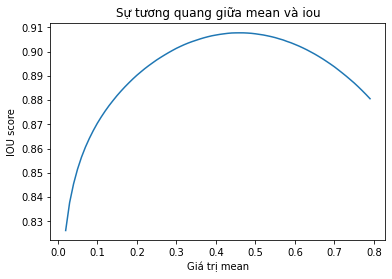

In [ ]:
mxmeans = np.arange(0.02,0.8,0.01)
mxblurs = np.array([cv2.blur(mxg,(5,5)) for mxg in mxgen])
print(mxblurs.shape)
scores = []
for mxmean in mxmeans:
  temp = mxblurs.copy()
  temp[temp < mxmean] = 0
  temp[temp >= mxmean] = 1  
  scores.append(pdata.iou_score(mytest[:,:,:,0],temp))
scores = np.array(scores)
plt.plot(mxmeans,scores)
plt.xlabel('Giá trị mean')
plt.ylabel('IOU score')
plt.title('Sự tương quang giữa mean và iou')
plt.show()

In [ ]:
df = pd.DataFrame({'mean': mxmeans,'score':scores})
dfpath = ae_path.replace('.h5','_best_mean.csv')
df.to_csv(dfpath)

In [ ]:
tindex = scores.argmax()
bmean = mxmeans[tindex]
print('best score: ',scores[tindex])
print('best mean: ',bmean)

best score:  0.907763565798687
best mean:  0.45999999999999996


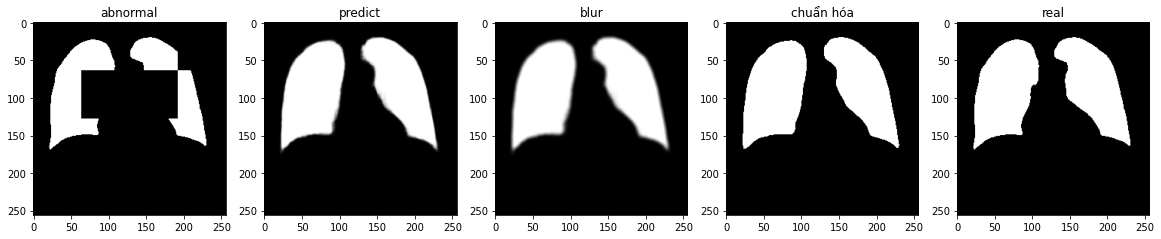

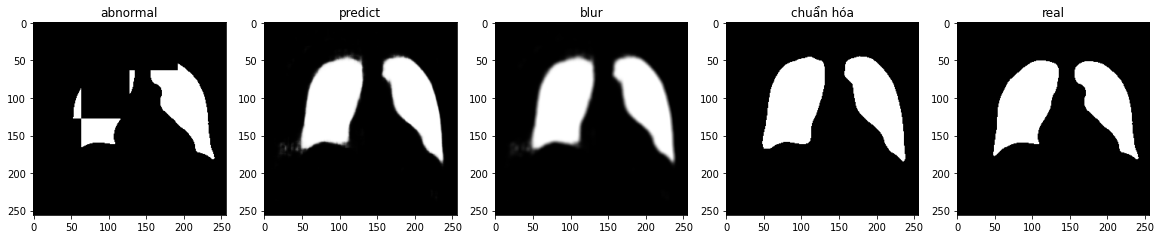

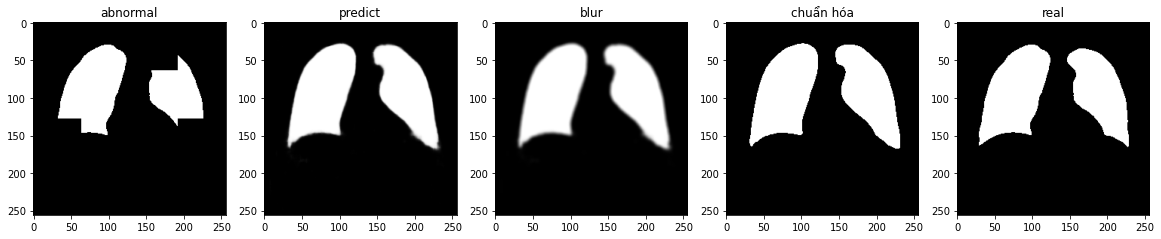

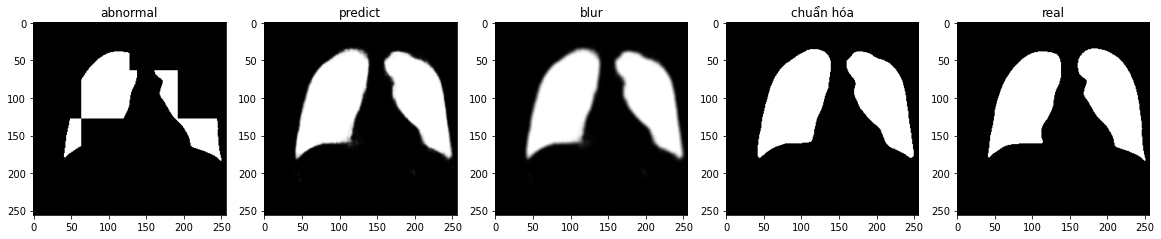

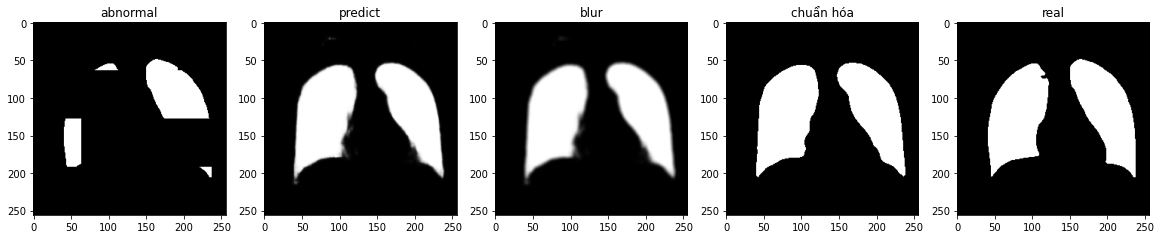

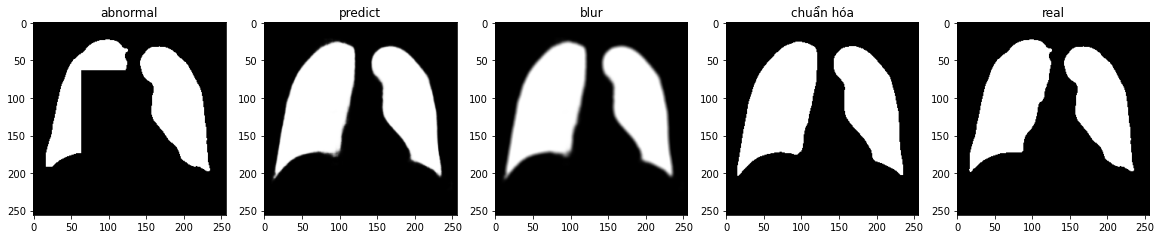

In [ ]:
rows = 1
cols = 5
for i in range(10):
  plt.figure(figsize=(20,10))
  plt.subplot(rows,cols,1)
  plt.imshow(mxtest[i,:,:,0],cmap='gray')
  plt.title('abnormal')
  plt.subplot(rows,cols,2)
  plt.imshow(mxgen[i,:,:,0],cmap='gray')
  plt.title('predict')
  plt.subplot(rows,cols,3)
  mxblur = mxblurs[i].copy()
  plt.imshow(mxblur,cmap='gray')
  plt.title('blur')
  plt.subplot(rows,cols,4)
  mxblur[mxblur < bmean] = 0
  mxblur[mxblur >= bmean] = 1
  plt.imshow(mxblur,cmap='gray')
  plt.title('chuẩn hóa')
  plt.subplot(rows,cols,5)
  plt.imshow(mytest[i,:,:,0],cmap='gray')
  plt.title('real')
  plt.show()

In [ ]:
mygen = autoencoder.predict(mytest,batch_size=5)

In [ ]:
myblurs = np.array([cv2.blur(myg,(5,5)) for myg in mygen])
mytemp = myblurs.copy()
mytemp[mytemp < bmean] = 0
mytemp[mytemp >= bmean] = 1
myscore = pdata.iou_score(mytest[:,:,:,0],mytemp)
print('Score với mask bình thường: ',myscore)

Score với mask bình thường:  0.9341301833713778


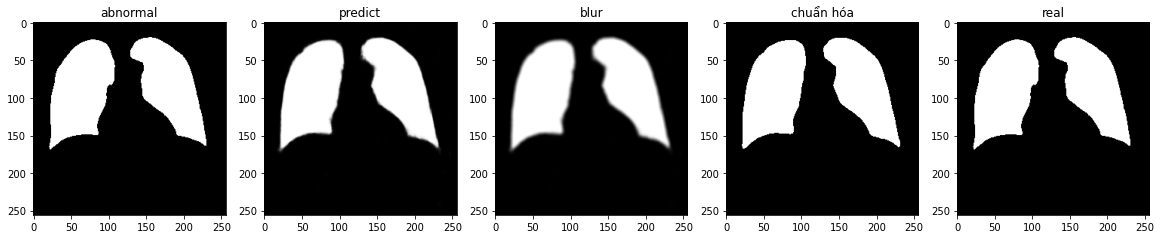

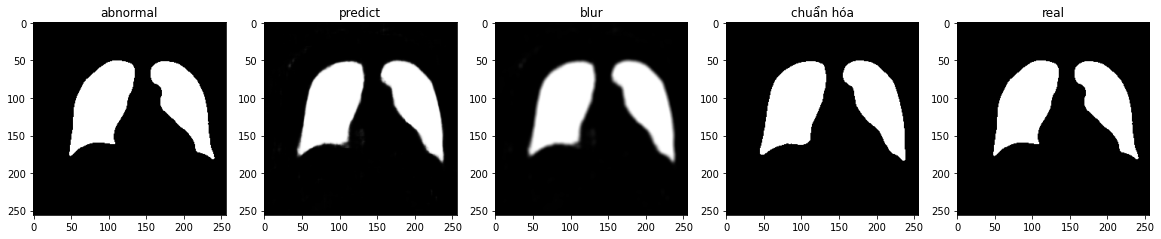

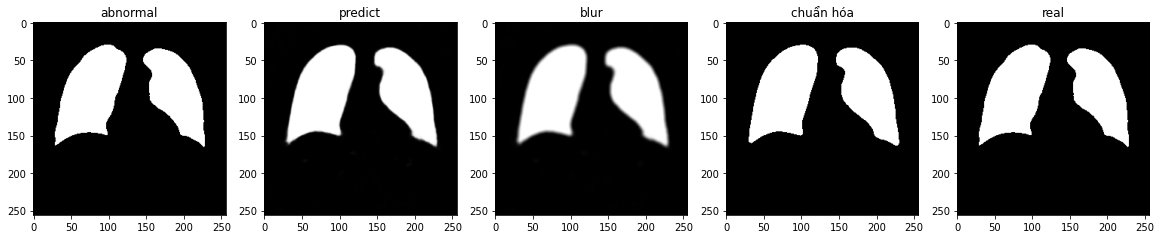

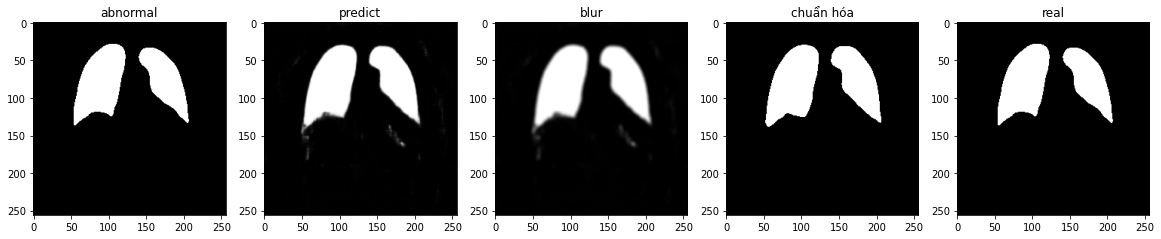

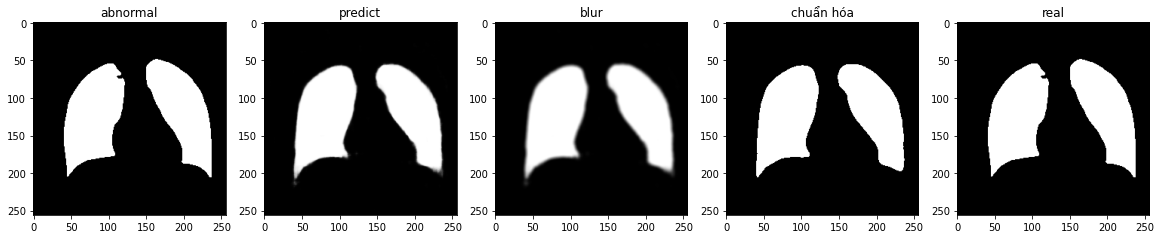

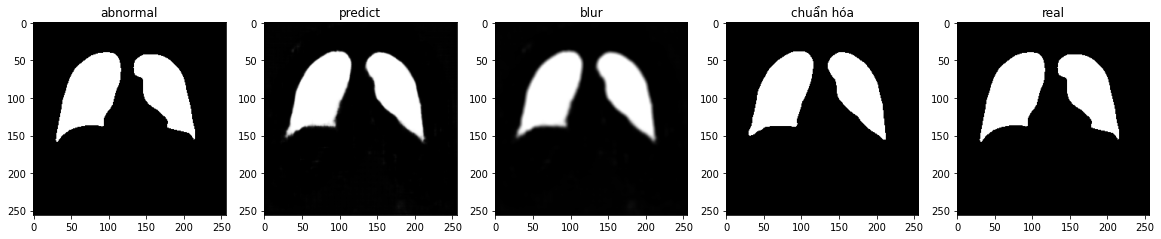

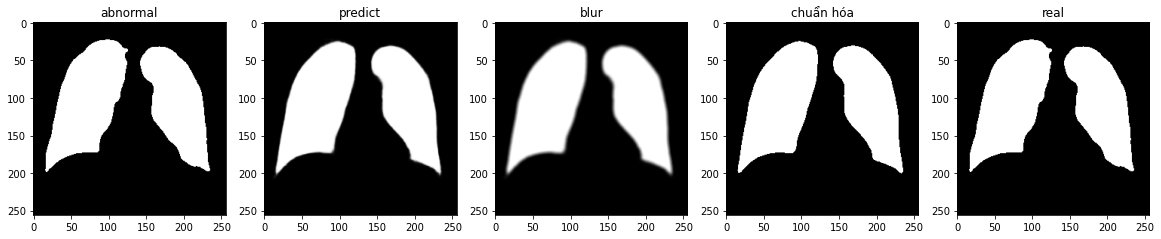

In [ ]:
rows = 1
cols = 5
for i in range(10):
  plt.figure(figsize=(20,10))
  plt.subplot(rows,cols,1)
  plt.imshow(mytest[i,:,:,0],cmap='gray')
  plt.title('abnormal')
  plt.subplot(rows,cols,2)
  plt.imshow(mygen[i,:,:,0],cmap='gray')
  plt.title('predict')
  plt.subplot(rows,cols,3)
  myblur = myblurs[i].copy()
  plt.imshow(myblur,cmap='gray')
  plt.title('blur')
  plt.subplot(rows,cols,4)
  myblur[myblur < bmean] = 0
  myblur[myblur >= bmean] = 1
  plt.imshow(myblur,cmap='gray')
  plt.title('chuẩn hóa')
  plt.subplot(rows,cols,5)
  plt.imshow(mytest[i,:,:,0],cmap='gray')
  plt.title('real')
  plt.show()

### **Get data for evaluate mask 1024x1024**

In [12]:
# resize ytest
mytest = mtest.copy()
mytest.shape

(310, 1024, 1024, 1)

In [13]:
mxtest = pdata.get_data_noise_vlazy(mytest,ntype=1)

### Evaluate autoencoder_mask_d512_f32x64x4_ep100_sigmoid

#### Load model

In [ ]:
ae_path = './model/checkpoint/autoencoder_mask_d512_f32x64x4_ep100_sigmoid/autoencoder_mask_d512_f32x64x4_ep100_sigmoid-0015-0.0156.h5'
autoencoder = load_model(ae_path,compile=False)

In [ ]:
autoencoder.summary()

Model: "autoencoder_mask_d512_f32x64x4_ep100_sigmoid"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1024, 1024, 1)]   0         
_________________________________________________________________
encoder_mask_d512_f32x64x4_e (None, 512)               33685696  
_________________________________________________________________
decoder_mask_d512_f32x64x4_e (None, 1024, 1024, 1)     33787585  
Total params: 67,473,281
Trainable params: 67,472,129
Non-trainable params: 1,152
_________________________________________________________________


#### Predict abnormal lần 1

In [ ]:
mxgen = autoencoder.predict(mxtest,batch_size=5)

(310, 1024, 1024)


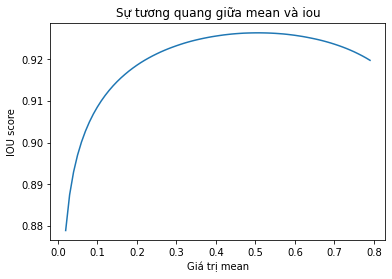

In [ ]:
mxmeans = np.arange(0.02,0.8,0.01)
mxblurs = np.array([cv2.blur(mxg,(5,5)) for mxg in mxgen])
print(mxblurs.shape)
scores = []
for mxmean in mxmeans:
  temp = mxblurs.copy()
  temp[temp < mxmean] = 0
  temp[temp >= mxmean] = 1  
  scores.append(pdata.iou_score(mytest[:,:,:,0],temp))
scores = np.array(scores)
plt.plot(mxmeans,scores)
plt.xlabel('Giá trị mean')
plt.ylabel('IOU score')
plt.title('Sự tương quang giữa mean và iou')
plt.show()

In [ ]:
df = pd.DataFrame({'mean': mxmeans,'score':scores})
dfpath = ae_path.replace('.h5','_best_mean.csv')
df.to_csv(dfpath)

In [ ]:
tindex = scores.argmax()
bmean = mxmeans[tindex]
print('best score: ',scores[tindex])
print('best mean: ',bmean)

best score:  0.9263741745696518
best mean:  0.5099999999999999


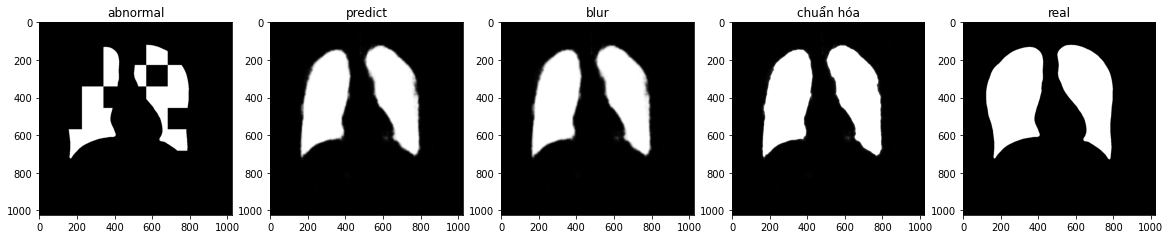

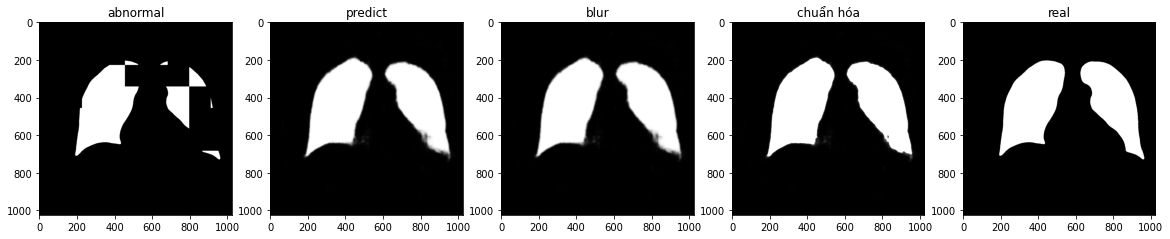

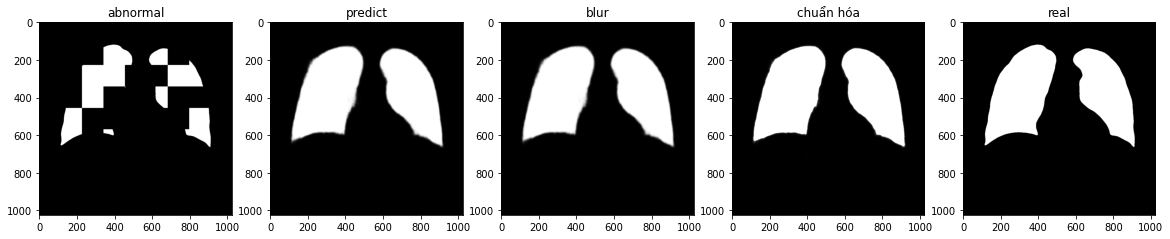

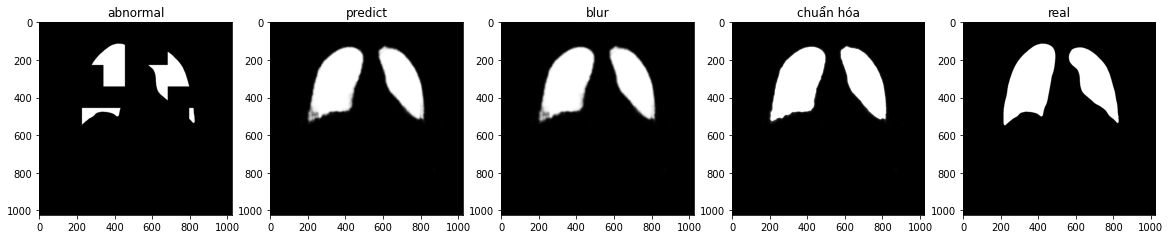

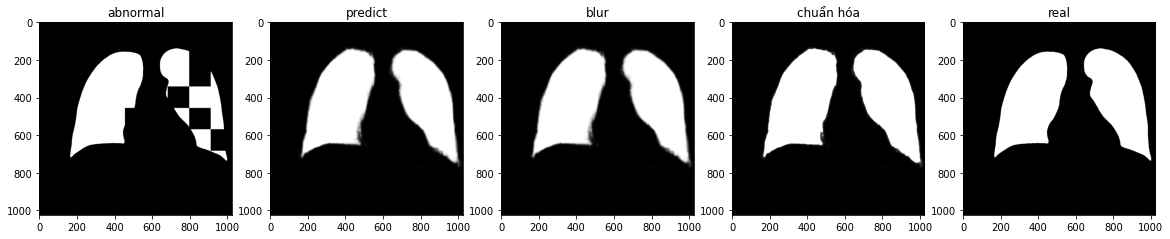

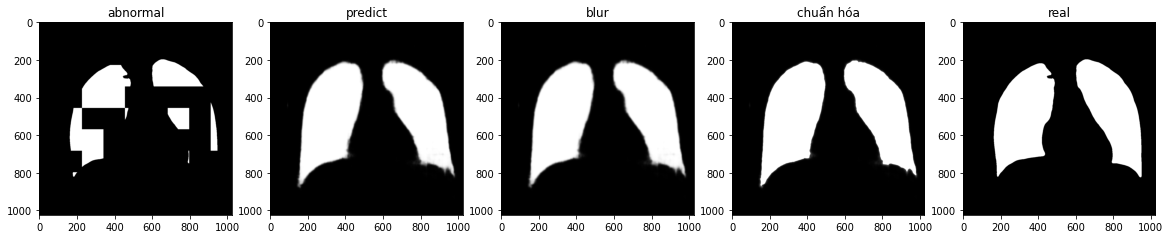

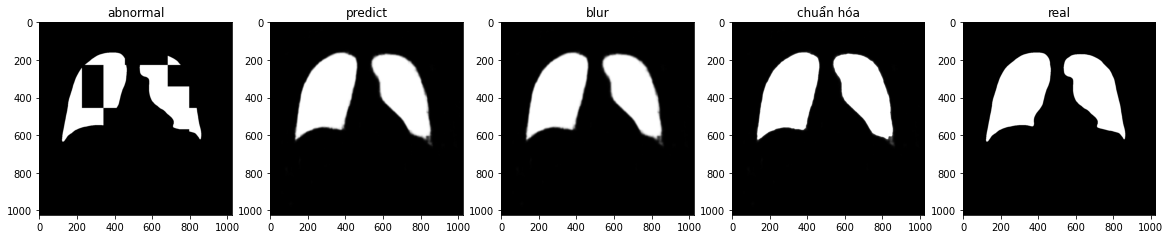

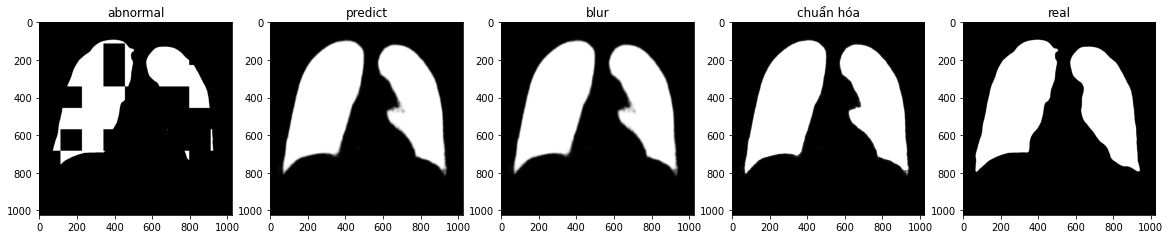

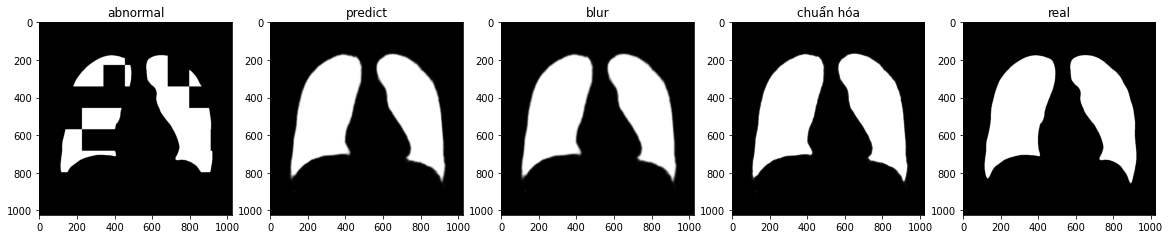

In [ ]:
rows = 1
cols = 5
for i in range(10):
  plt.figure(figsize=(20,10))
  plt.subplot(rows,cols,1)
  plt.imshow(mxtest[i,:,:,0],cmap='gray')
  plt.title('abnormal')
  plt.subplot(rows,cols,2)
  plt.imshow(mxgen[i,:,:,0],cmap='gray')
  plt.title('predict')
  plt.subplot(rows,cols,3)
  mxblur = mxblurs[i].copy()
  plt.imshow(mxblur,cmap='gray')
  plt.title('blur')
  plt.subplot(rows,cols,4)
  # mxblur[mxblur < bmean] = 0
  # mxblur[mxblur >= bmean] = 1
  mxblur[mxblur >= 0.4] = 1
  plt.imshow(mxblur,cmap='gray')
  plt.title('chuẩn hóa')
  plt.subplot(rows,cols,5)
  plt.imshow(mytest[i,:,:,0],cmap='gray')
  plt.title('real')
  plt.show()

#### Predict abnormal lần 2

In [ ]:
mxtest2 = mxblurs.copy()
mxtest2[mxtest2 < bmean] = 0
mxtest2[mxtest2 >= bmean] = 1

In [ ]:
mxtest2 = np.expand_dims(mxtest2,axis=-1)

In [ ]:
mxgen2 = autoencoder.predict(mxtest2,batch_size=5)

(310, 1024, 1024)


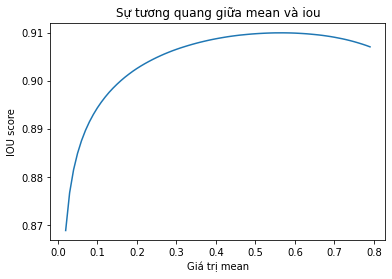

In [ ]:
mxmeans = np.arange(0.02,0.8,0.01)
mxblur2s = np.array([cv2.blur(mxg,(5,5)) for mxg in mxgen2])
print(mxblur2s.shape)
scores = []
for mxmean in mxmeans:
  temp = mxblur2s.copy()
  temp[temp < mxmean] = 0
  temp[temp >= mxmean] = 1  
  scores.append(pdata.iou_score(mytest[:,:,:,0],temp))
scores = np.array(scores)
plt.plot(mxmeans,scores)
plt.xlabel('Giá trị mean')
plt.ylabel('IOU score')
plt.title('Sự tương quang giữa mean và iou')
plt.show()

In [ ]:
df = pd.DataFrame({'mean': mxmeans,'score':scores})
dfpath = ae_path.replace('.h5','_best_mean_n2.csv')
df.to_csv(dfpath)

In [ ]:
tindex = scores.argmax()
bmean = mxmeans[tindex]
print('best score: ',scores[tindex])
print('best mean: ',bmean)

best score:  0.9099839894614677
best mean:  0.57


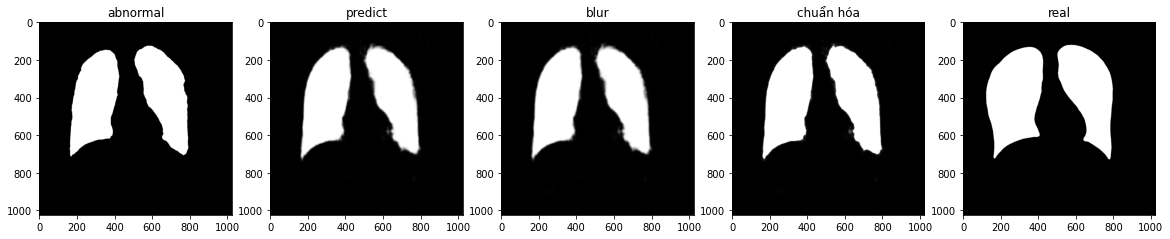

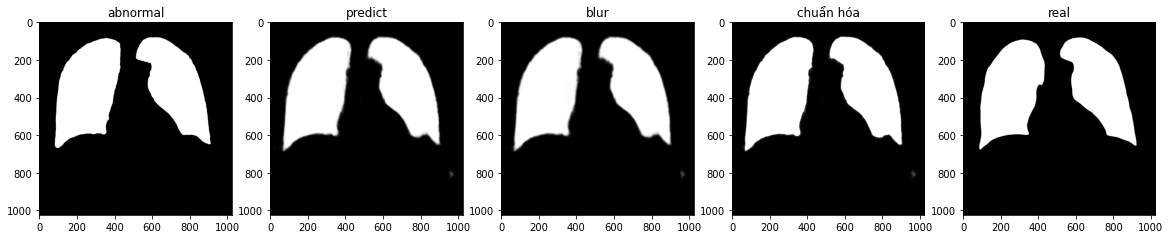

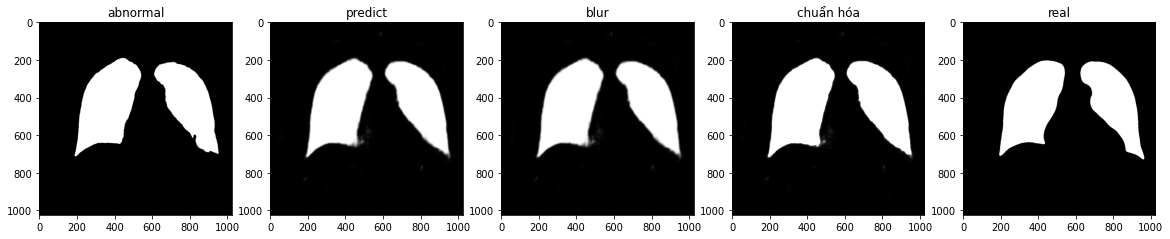

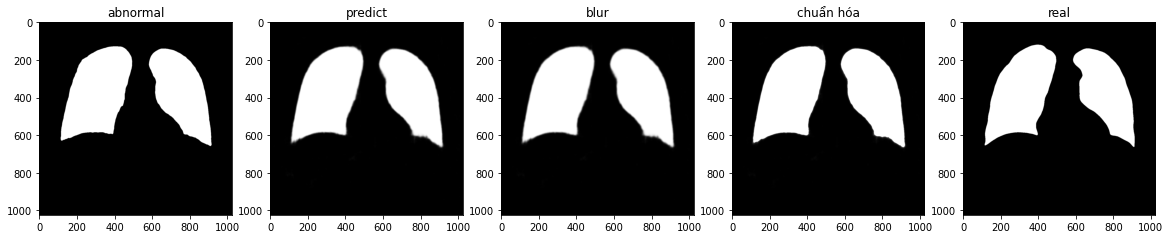

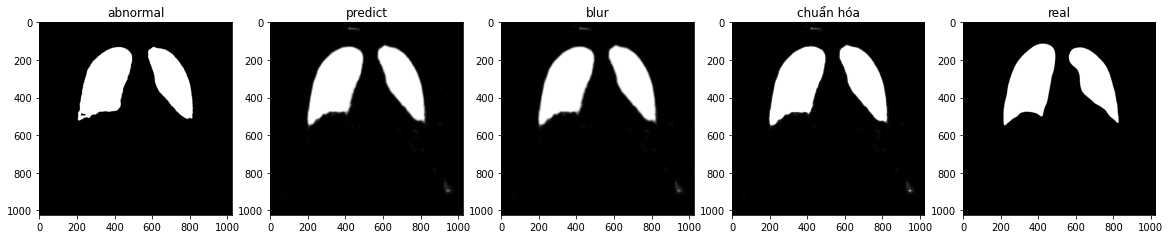

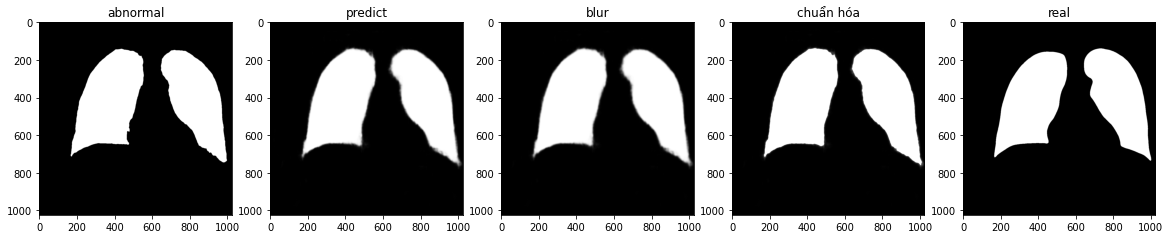

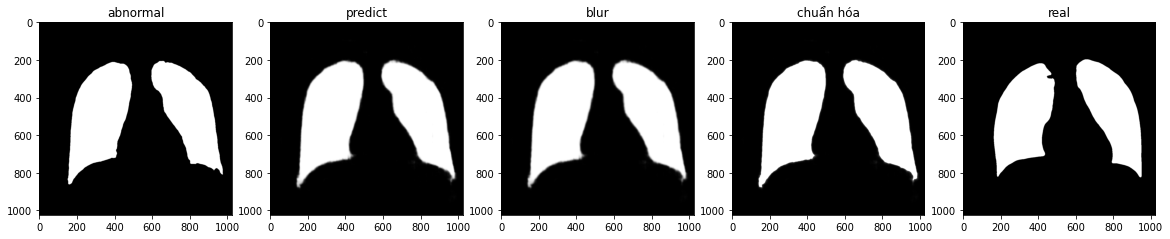

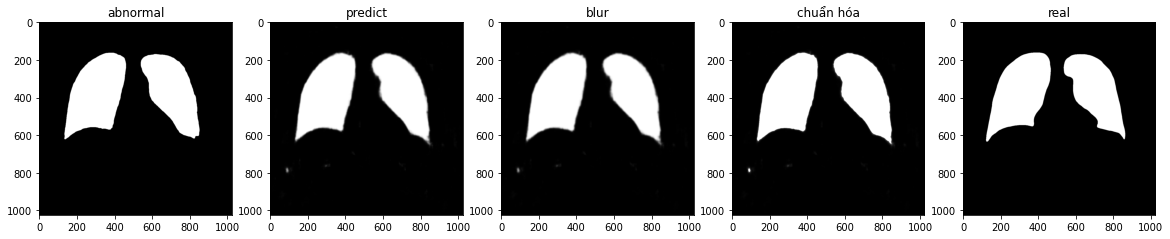

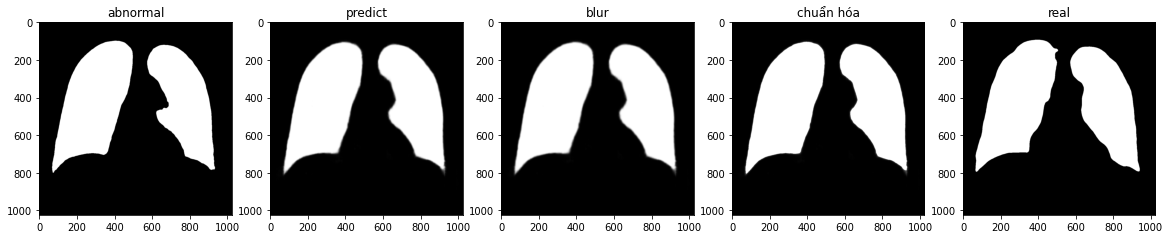

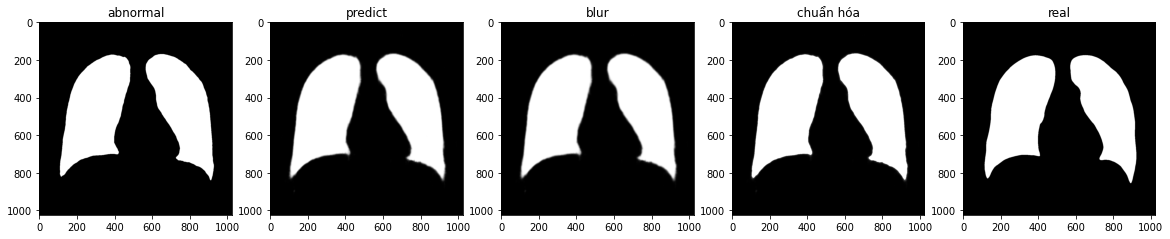

In [ ]:
rows = 1
cols = 5
for i in range(10):
  plt.figure(figsize=(20,10))
  plt.subplot(rows,cols,1)
  plt.imshow(mxtest2[i,:,:,0],cmap='gray')
  plt.title('abnormal')
  plt.subplot(rows,cols,2)
  plt.imshow(mxgen2[i,:,:,0],cmap='gray')
  plt.title('predict')
  plt.subplot(rows,cols,3)
  mxblur = mxblur2s[i].copy()
  plt.imshow(mxblur,cmap='gray')
  plt.title('blur')
  plt.subplot(rows,cols,4)
  # mxblur[mxblur < bmean] = 0
  # mxblur[mxblur >= bmean] = 1
  mxblur[mxblur >= 0.4] = 1
  plt.imshow(mxblur,cmap='gray')
  plt.title('chuẩn hóa')
  plt.subplot(rows,cols,5)
  plt.imshow(mytest[i,:,:,0],cmap='gray')
  plt.title('real')
  plt.show()

#### Predict trên dữ liệu normal lần 1

In [ ]:
mygen = autoencoder.predict(mytest,batch_size=5)

In [ ]:
myblurs = np.array([cv2.blur(myg,(5,5)) for myg in mygen])
mytemp = myblurs.copy()
mytemp[mytemp < bmean] = 0
mytemp[mytemp >= bmean] = 1
myscore = pdata.iou_score(mytest[:,:,:,0],mytemp)
print('Score với mask bình thường: ',myscore)

Score với mask bình thường:  0.9415089031270928


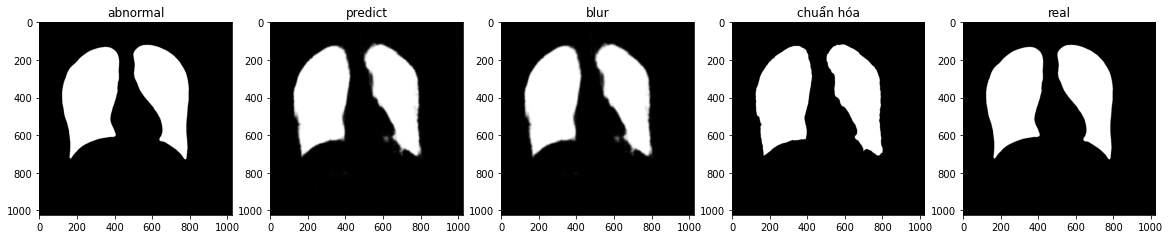

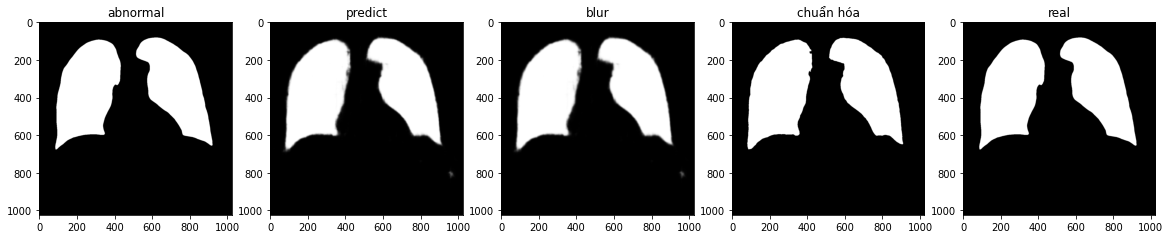

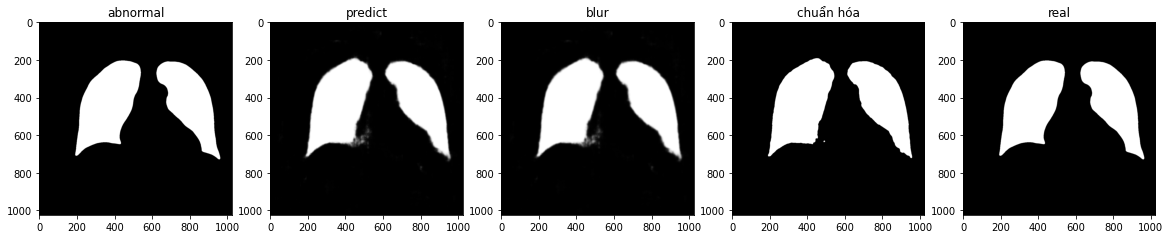

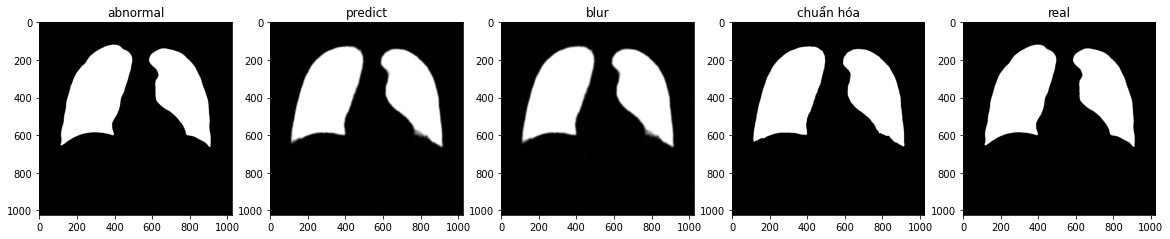

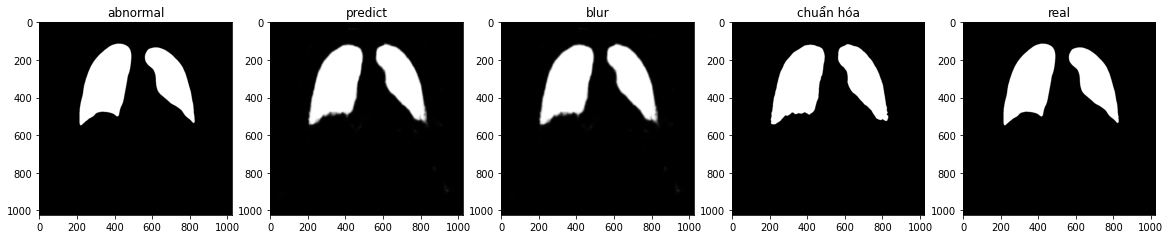

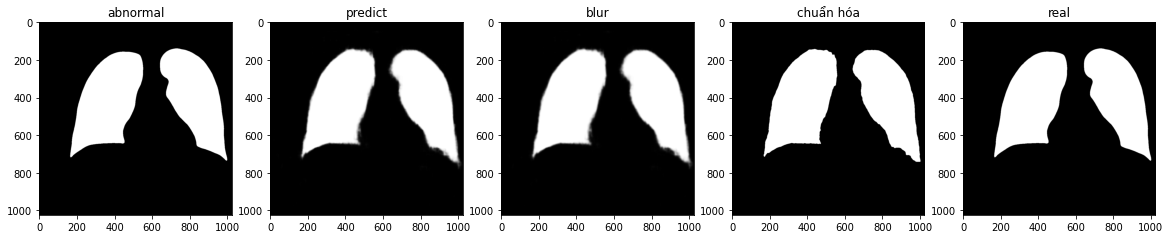

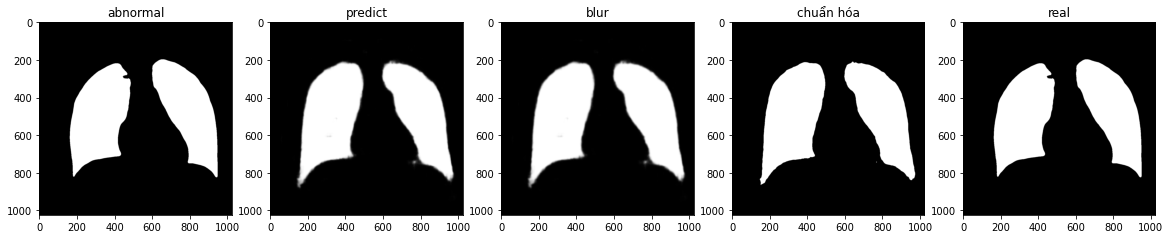

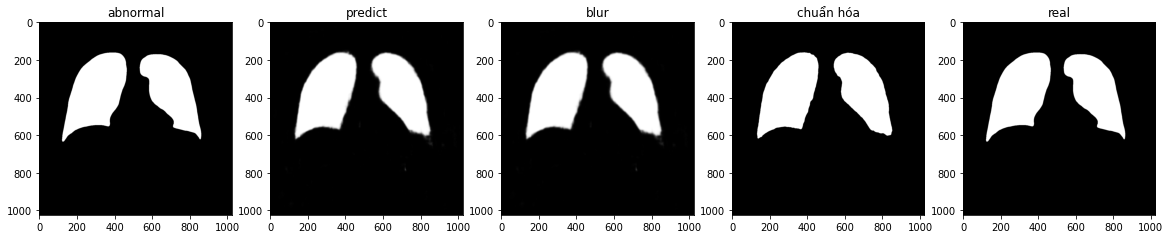

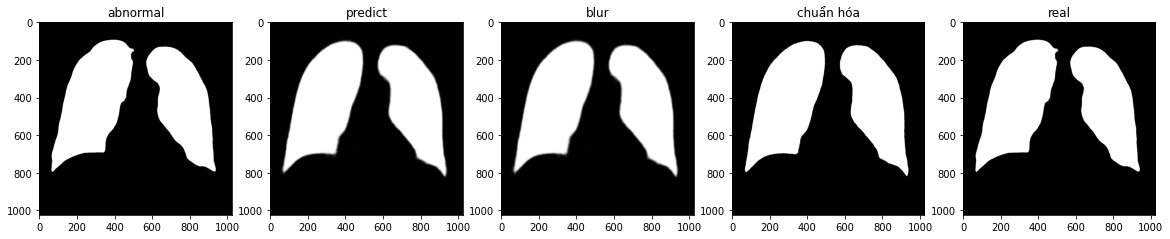

In [ ]:
rows = 1
cols = 5
for i in range(10):
  plt.figure(figsize=(20,10))
  plt.subplot(rows,cols,1)
  plt.imshow(mytest[i,:,:,0],cmap='gray')
  plt.title('abnormal')
  plt.subplot(rows,cols,2)
  plt.imshow(mygen[i,:,:,0],cmap='gray')
  plt.title('predict')
  plt.subplot(rows,cols,3)
  myblur = myblurs[i].copy()
  plt.imshow(myblur,cmap='gray')
  plt.title('blur')
  plt.subplot(rows,cols,4)
  myblur[myblur < bmean] = 0
  myblur[myblur >= bmean] = 1
  plt.imshow(myblur,cmap='gray')
  plt.title('chuẩn hóa')
  plt.subplot(rows,cols,5)
  plt.imshow(mytest[i,:,:,0],cmap='gray')
  plt.title('real')
  plt.show()

### Evaluate autoencoder_mask_c128x128x64x6_f32x64x2_ep150_sigmoid

#### Load model

In [ ]:
ae_path = './model/checkpoint/autoencoder_mask_c128x128x64x6_f32x64x2_ep150_sigmoid/autoencoder_mask_c128x128x64x6_f32x64x2_ep150_sigmoid-0033-0.0065.h5'
autoencoder = load_model(ae_path,compile=False)

#### Predict abnormal


In [ ]:
mxgen = autoencoder.predict(mxtest,batch_size=5)

In [ ]:
mxmeans = np.arange(0.02,0.8,0.01)
mxblurs = np.array([cv2.blur(mxg,(5,5)) for mxg in mxgen])
print(mxblurs.shape)
scores = []
for mxmean in mxmeans:
  temp = mxblurs.copy()
  temp[temp < mxmean] = 0
  temp[temp >= mxmean] = 1  
  scores.append(pdata.iou_score(mytest[:,:,:,0],temp))
scores = np.array(scores)
plt.plot(mxmeans,scores)
plt.xlabel('Giá trị mean')
plt.ylabel('IOU score')
plt.title('Sự tương quang giữa mean và iou')
plt.show()

(310, 1024, 1024)


In [ ]:
df = pd.DataFrame({'mean': mxmeans,'score':scores})
dfpath = ae_path.replace('.h5','_best_mean.csv')
df.to_csv(dfpath)

In [ ]:
tindex = scores.argmax()
bmean = mxmeans[tindex]
print('best score: ',scores[tindex])
print('best mean: ',bmean)

best score:  0.9668724727257019
best mean:  0.49999999999999994


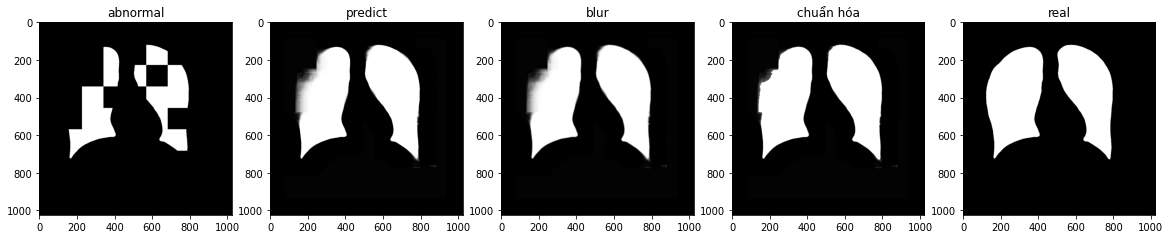

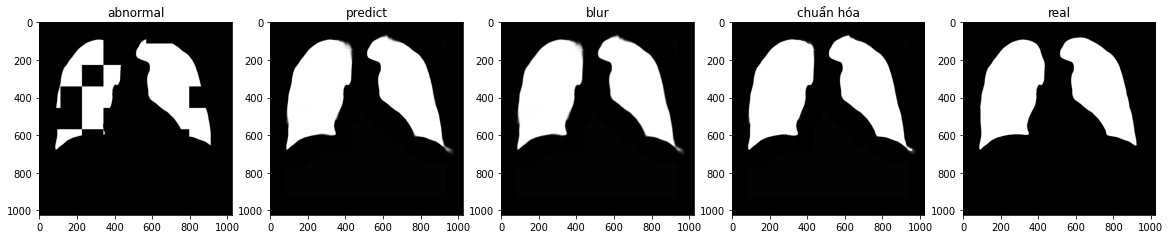

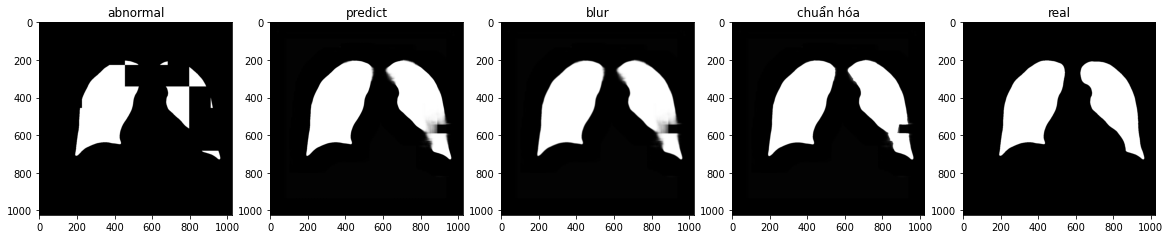

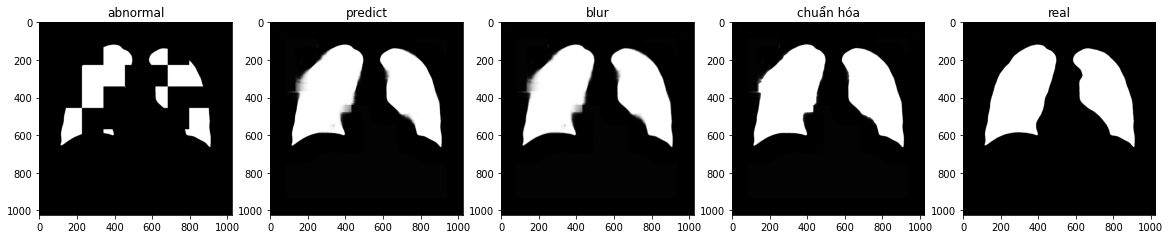

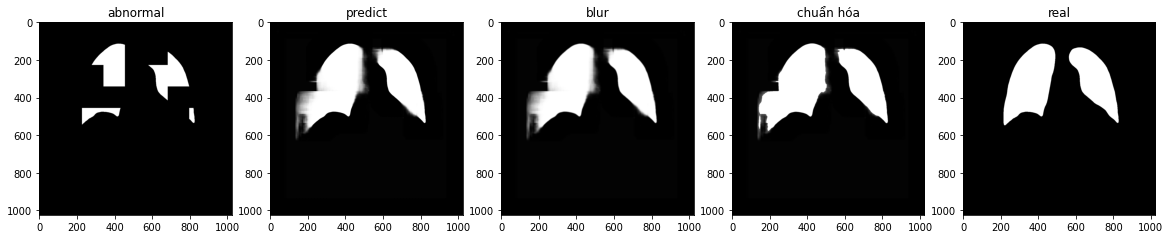

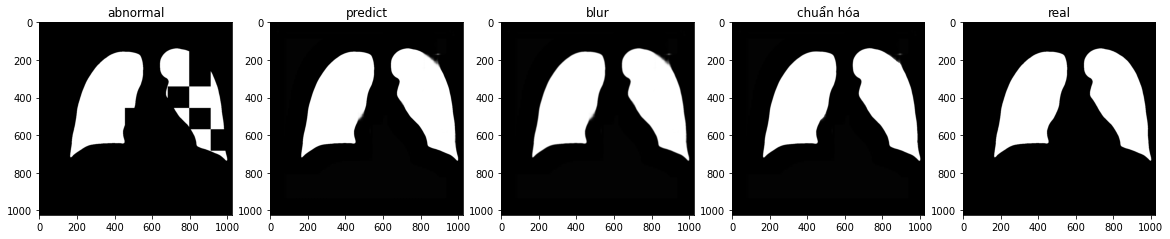

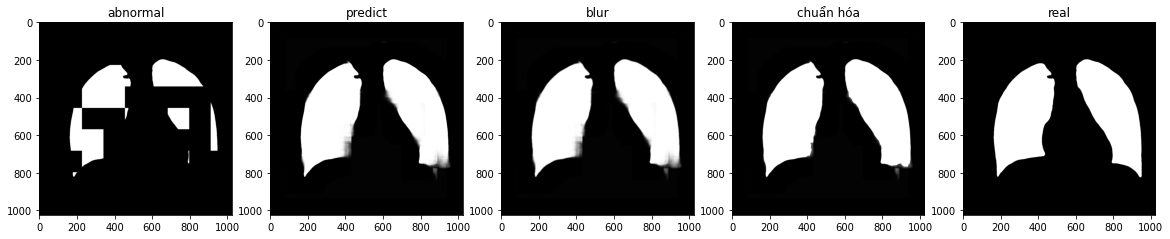

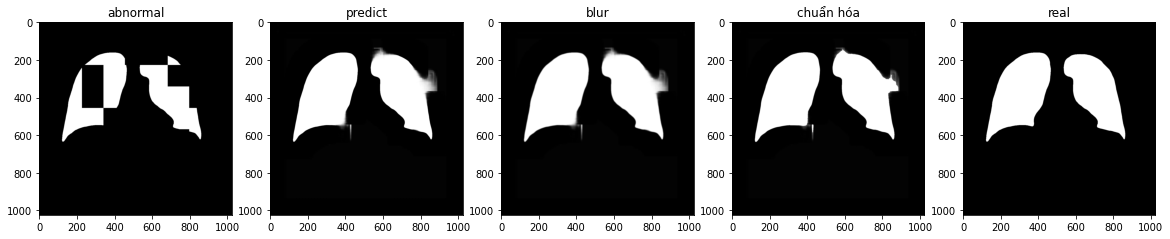

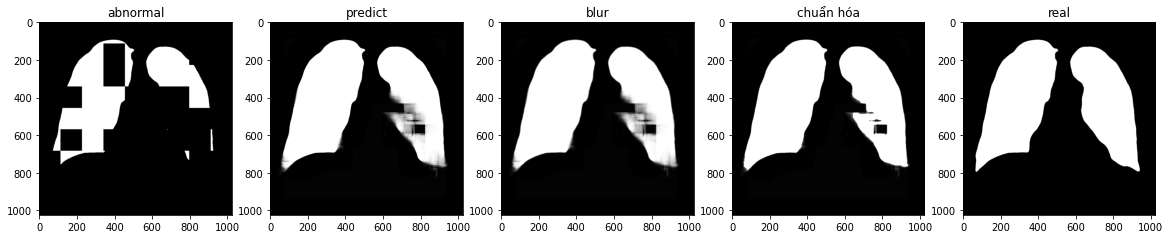

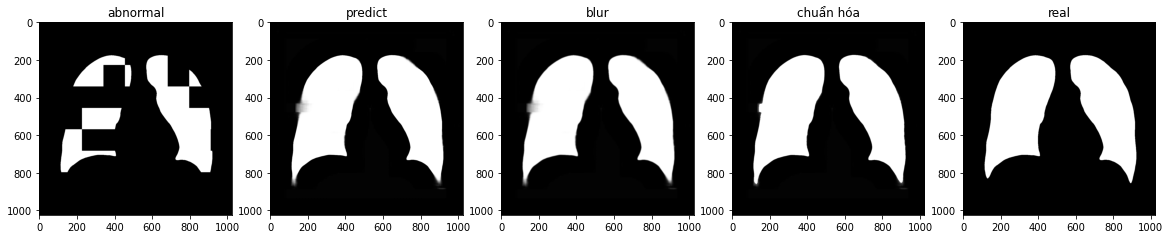

In [ ]:
rows = 1
cols = 5
for i in range(10):
  plt.figure(figsize=(20,10))
  plt.subplot(rows,cols,1)
  plt.imshow(mxtest[i,:,:,0],cmap='gray')
  plt.title('abnormal')
  plt.subplot(rows,cols,2)
  plt.imshow(mxgen[i,:,:,0],cmap='gray')
  plt.title('predict')
  plt.subplot(rows,cols,3)
  mxblur = mxblurs[i].copy()
  plt.imshow(mxblur,cmap='gray')
  plt.title('blur')
  plt.subplot(rows,cols,4)
  # mxblur[mxblur < bmean] = 0
  # mxblur[mxblur >= bmean] = 1
  mxblur[mxblur >= 0.4] = 1
  plt.imshow(mxblur,cmap='gray')
  plt.title('chuẩn hóa')
  plt.subplot(rows,cols,5)
  plt.imshow(mytest[i,:,:,0],cmap='gray')
  plt.title('real')
  plt.show()

#### Predict trên dữ liệu normal

In [ ]:
mygen = autoencoder.predict(mytest,batch_size=5)

In [ ]:
myblurs = np.array([cv2.blur(myg,(5,5)) for myg in mygen])
mytemp = myblurs.copy()
mytemp[mytemp < bmean] = 0
mytemp[mytemp >= bmean] = 1
myscore = pdata.iou_score(mytest[:,:,:,0],mytemp)
print('Score với mask bình thường: ',myscore)

Score với mask bình thường:  0.9989841973187383


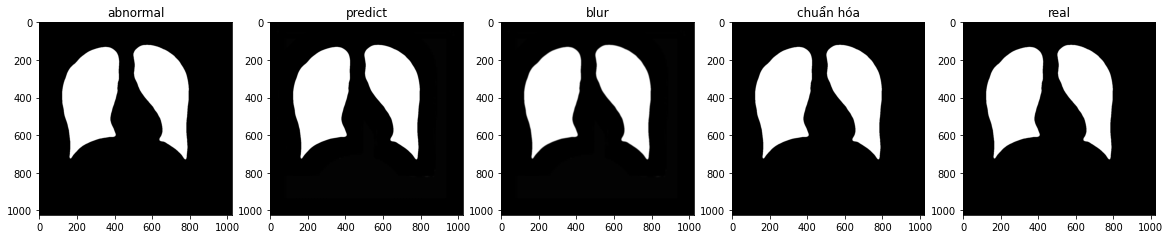

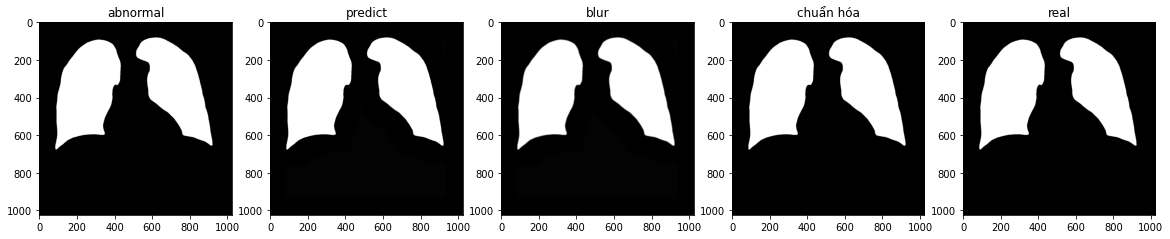

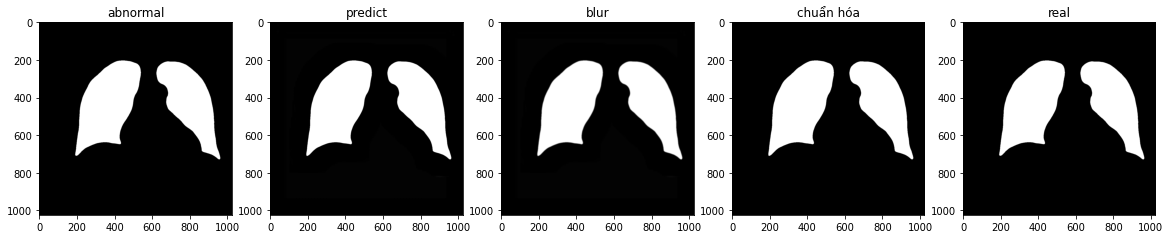

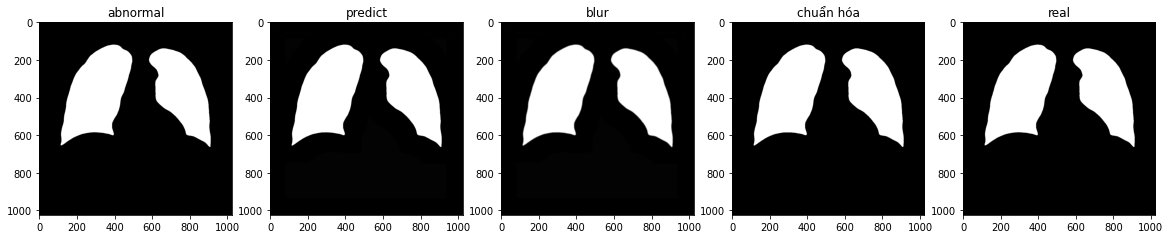

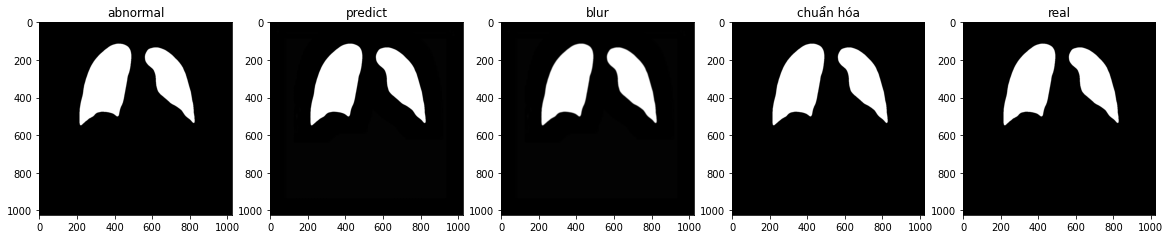

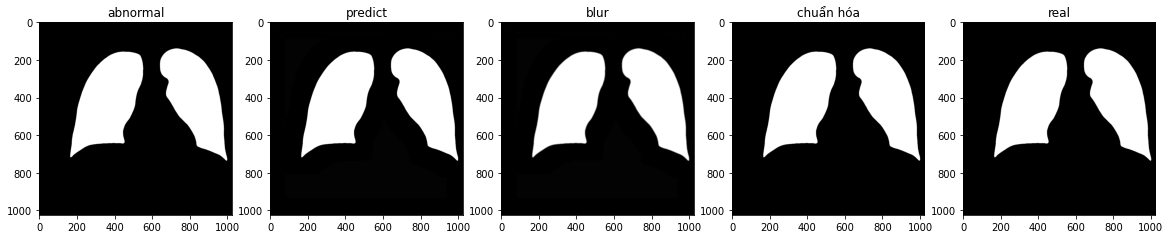

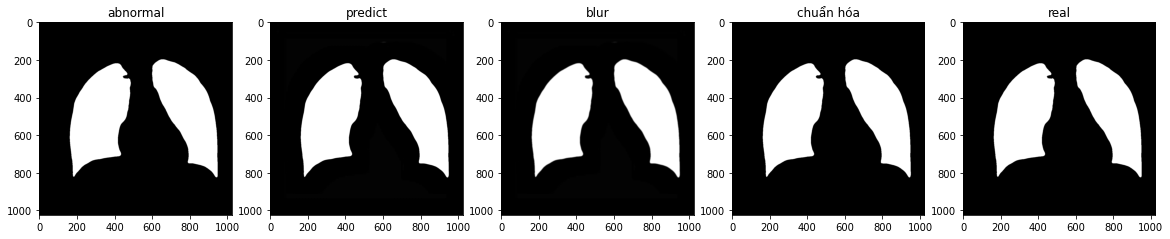

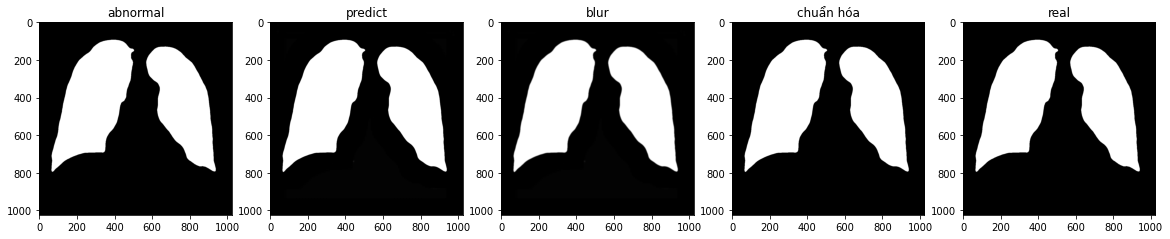

In [ ]:
rows = 1
cols = 5
for i in range(10):
  plt.figure(figsize=(20,10))
  plt.subplot(rows,cols,1)
  plt.imshow(mytest[i,:,:,0],cmap='gray')
  plt.title('abnormal')
  plt.subplot(rows,cols,2)
  plt.imshow(mygen[i,:,:,0],cmap='gray')
  plt.title('predict')
  plt.subplot(rows,cols,3)
  myblur = myblurs[i].copy()
  plt.imshow(myblur,cmap='gray')
  plt.title('blur')
  plt.subplot(rows,cols,4)
  myblur[myblur < bmean] = 0
  myblur[myblur >= bmean] = 1
  plt.imshow(myblur,cmap='gray')
  plt.title('chuẩn hóa')
  plt.subplot(rows,cols,5)
  plt.imshow(mytest[i,:,:,0],cmap='gray')
  plt.title('real')
  plt.show()

### Evaluate 
Step 1: autoencoder_mask_d512_f32x64x4_ep100_sigmoid

Step 2: autoencoder_mask_c128x128x64x6_f32x64x2_ep150_sigmoid

#### Load model

In [ ]:
ae_path1 = './model/checkpoint/autoencoder_mask_d512_f32x64x4_ep100_sigmoid/autoencoder_mask_d512_f32x64x4_ep100_sigmoid-0015-0.0156.h5'
autoencoder2 = load_model(ae_path1,compile=False)
ae_path2 = './model/checkpoint/autoencoder_mask_c128x128x64x6_f32x64x2_ep150_sigmoid/autoencoder_mask_c128x128x64x6_f32x64x2_ep150_sigmoid-0033-0.0065.h5'
autoencoder1 = load_model(ae_path2,compile=False)

#### Step 1

In [ ]:
mxgen = autoencoder1.predict(mxtest,batch_size=5)
mxblurs = np.array([cv2.blur(mxg,(9,9)) for mxg in mxgen])
bmean = pdata.get_best_mean(ae_path1)
mxblurs[mxblurs < bmean] = 0
mxblurs[mxblurs >= bmean] = 1

#### Step 2

In [ ]:
mxgen2 = autoencoder2.predict(mxblurs,batch_size=5)
mxblur2s = np.array([cv2.blur(mxg,(9,9)) for mxg in mxgen2])

In [ ]:
bmean2 = pdata.get_best_mean(ae_path2)
mxblur2s[mxblur2s < bmean2] = 0
mxblur2s[mxblur2s >= bmean2] = 1

#### View

In [ ]:
score = pdata.iou_score(mxblur2s,mytest[:,:,:,0])
score

0.9306484466227474

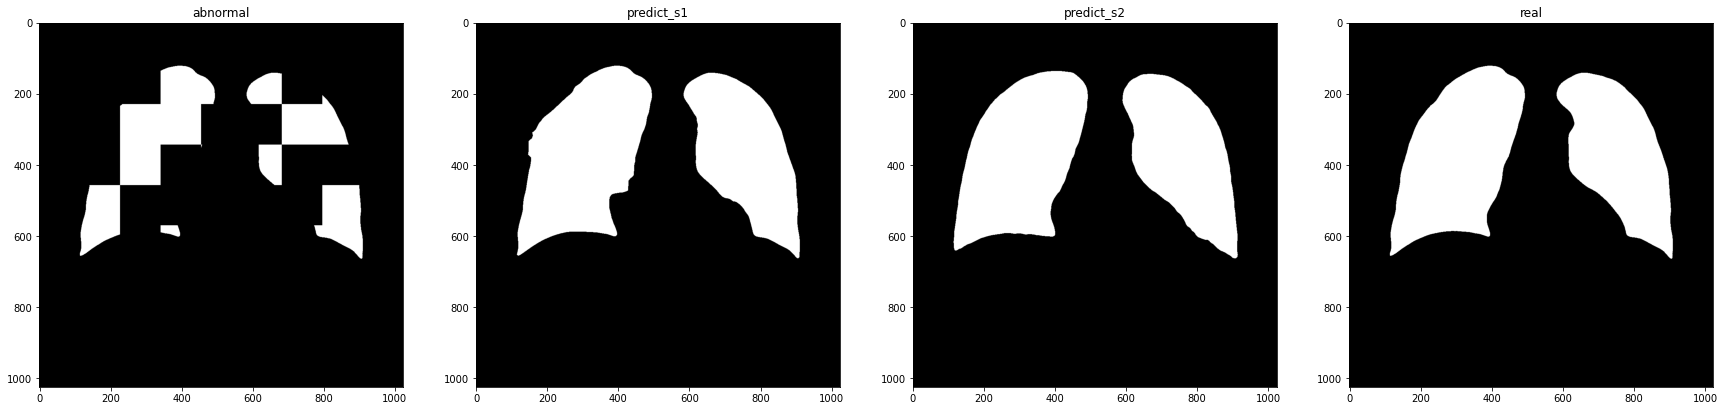

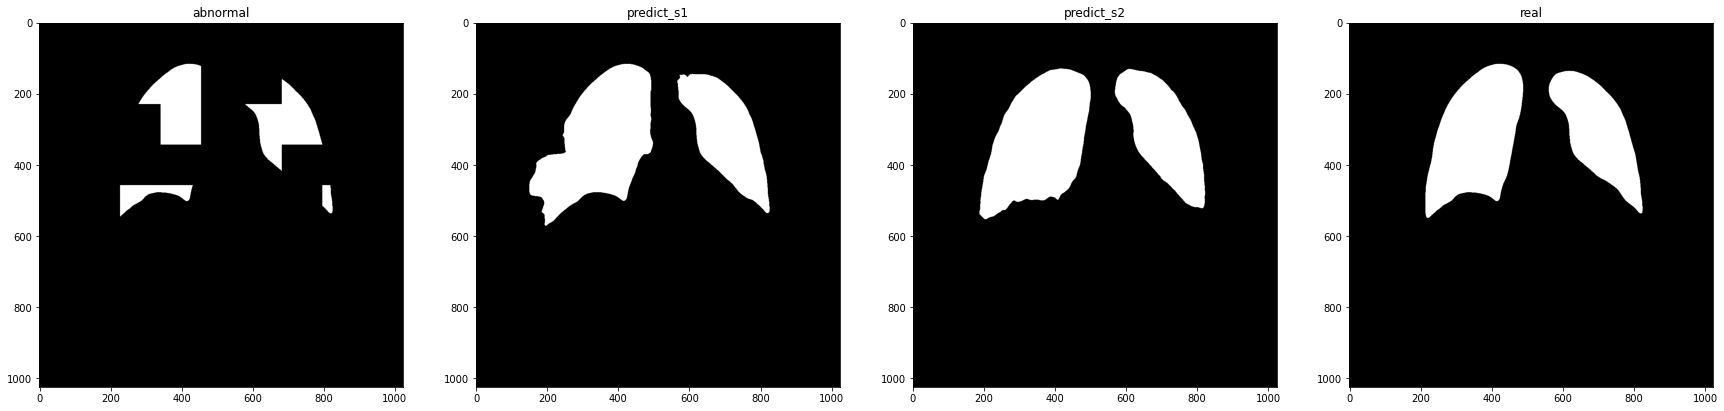

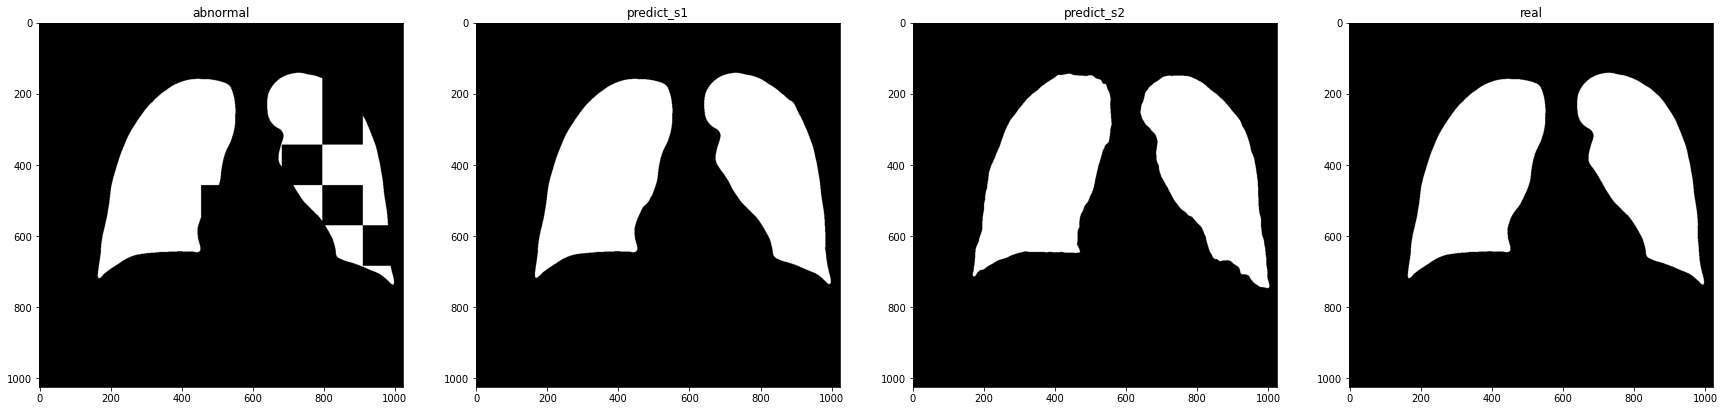

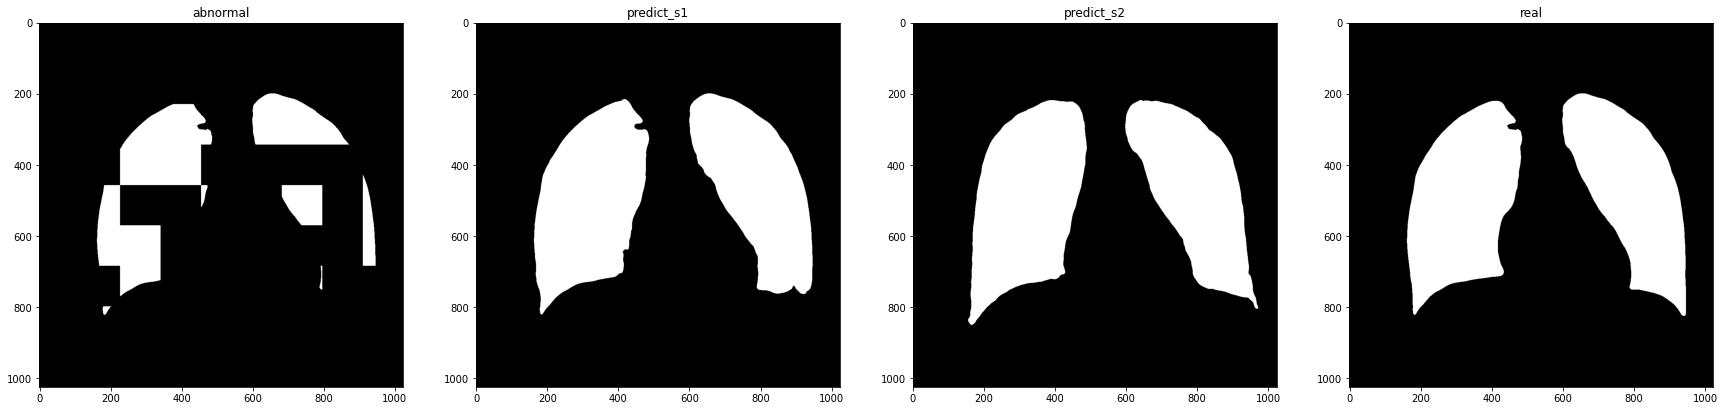

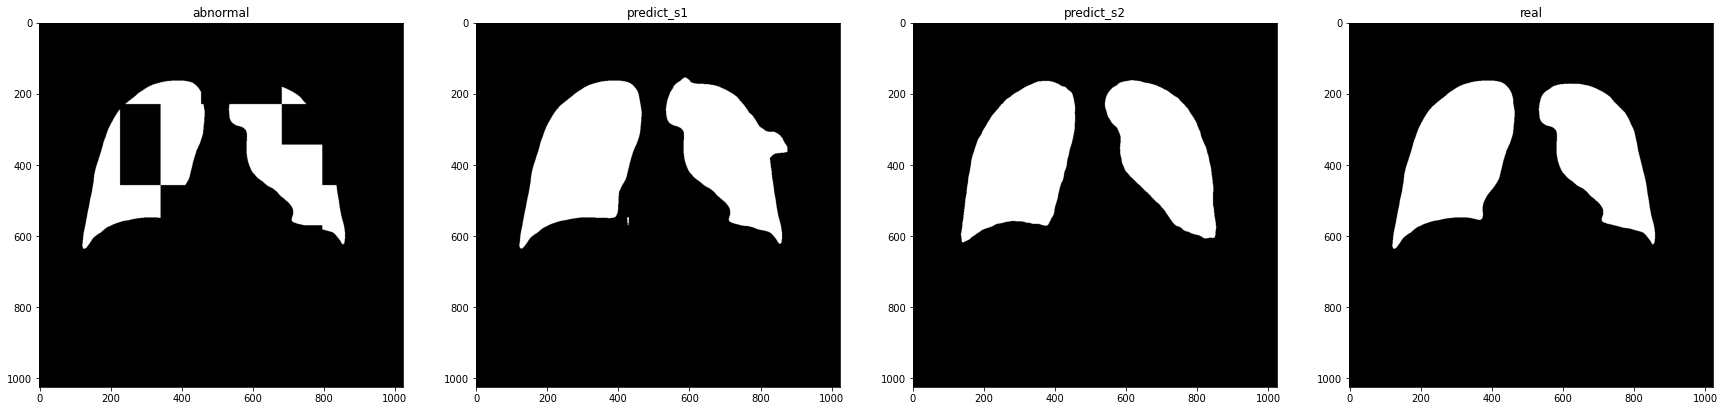

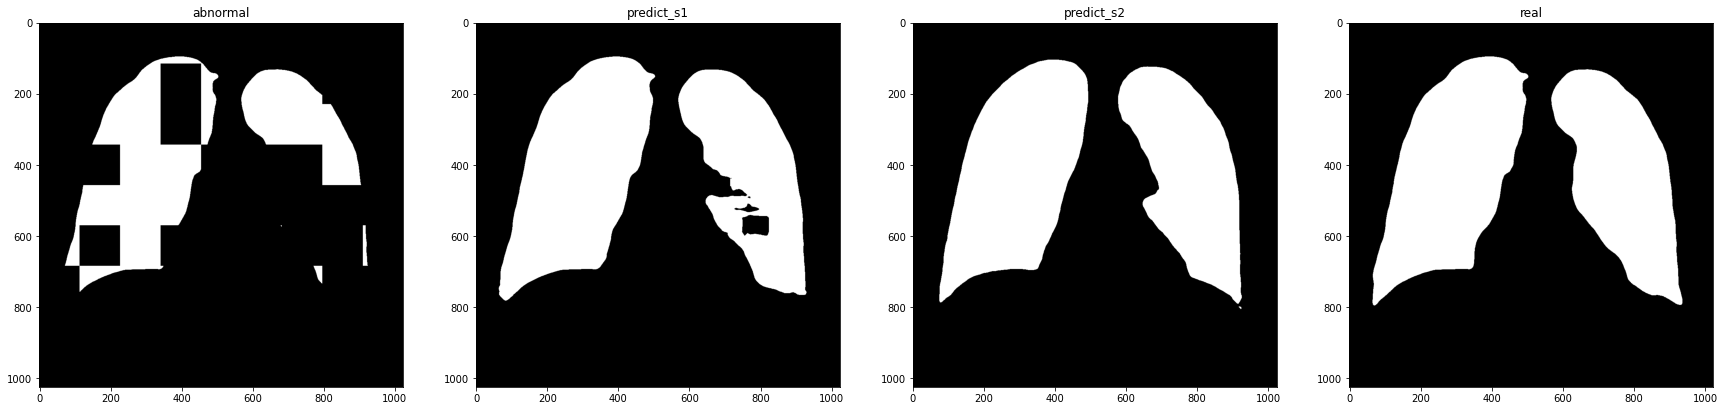

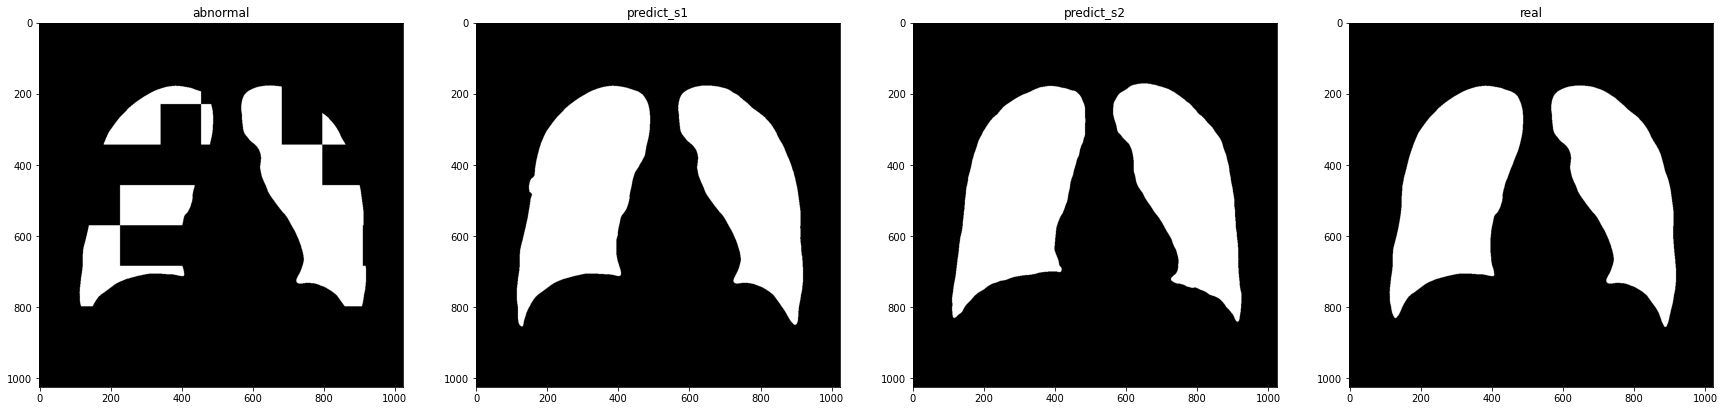

In [ ]:
rows = 1
cols = 4
for i in range(10):
  plt.figure(figsize=(30,15))
  plt.subplot(rows,cols,1)
  plt.imshow(mxtest[i,:,:,0],cmap='gray')
  plt.title('abnormal')
  plt.subplot(rows,cols,2)
  plt.imshow(mxblurs[i],cmap='gray')
  plt.title('predict_s1')
  plt.subplot(rows,cols,3)
  plt.imshow(mxblur2s[i],cmap='gray')
  plt.title('predict_s2')
  plt.subplot(rows,cols,4)
  plt.imshow(mytest[i,:,:,0],cmap='gray')
  plt.title('real')
  plt.show()

### Evaluate autoencoder_mask_c256x256x256x2_f64_64_ep100_relu



#### Load model

In [ ]:
ae_path = './model/checkpoint/autoencoder_c256x256x256x2_f64_64_ep100_relu/autoencoder_c256x256x256x2_f64_64_ep100_relu-0025-0.0423.h5'
autoencoder = load_model(ae_path,compile=False)

#### Predict abnormal


In [ ]:
mxgen = autoencoder.predict(mxtest,batch_size=5)

(310, 1024, 1024)


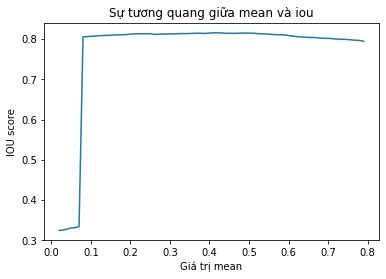

In [ ]:
mxmeans = np.arange(0.02,0.8,0.01)
mxblurs = np.array([cv2.blur(mxg,(5,5)) for mxg in mxgen])
print(mxblurs.shape)
scores = []
for mxmean in mxmeans:
  temp = mxblurs.copy()
  temp[temp < mxmean] = 0
  temp[temp >= mxmean] = 1  
  scores.append(pdata.iou_score(mytest[:,:,:,0],temp))
scores = np.array(scores)
plt.plot(mxmeans,scores)
plt.xlabel('Giá trị mean')
plt.ylabel('IOU score')
plt.title('Sự tương quang giữa mean và iou')
plt.show()

In [ ]:
df = pd.DataFrame({'mean': mxmeans,'score':scores})
dfpath = ae_path.replace('.h5','_best_mean.csv')
df.to_csv(dfpath)

In [ ]:
tindex = scores.argmax()
bmean = mxmeans[tindex]
print('best score: ',scores[tindex])
print('best mean: ',bmean)

best score:  0.8155459309338228
best mean:  0.41


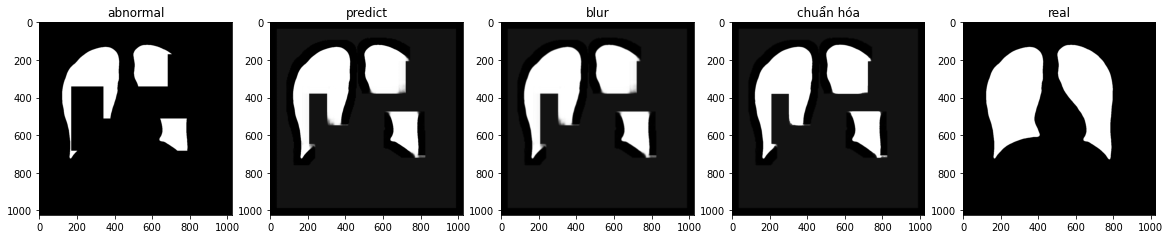

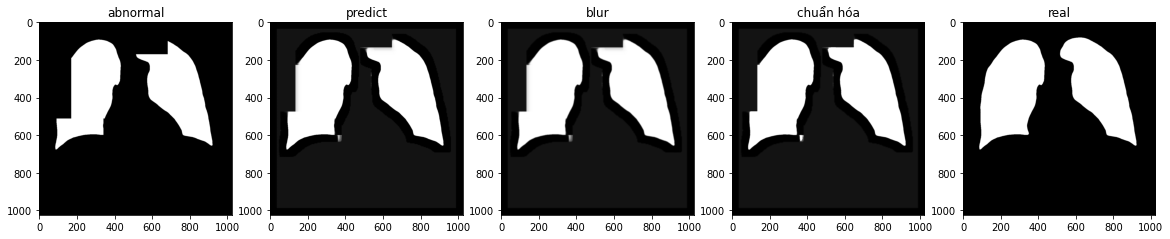

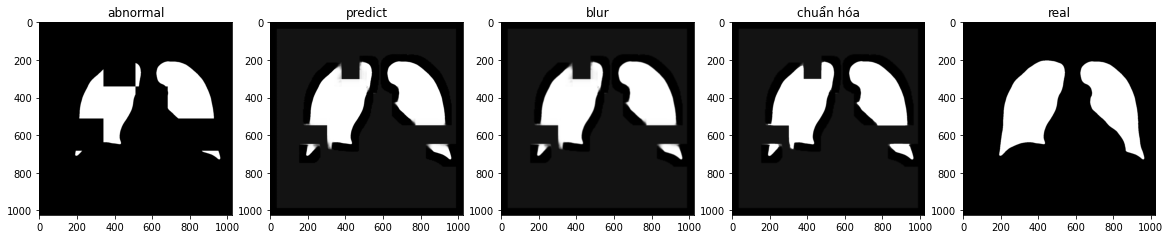

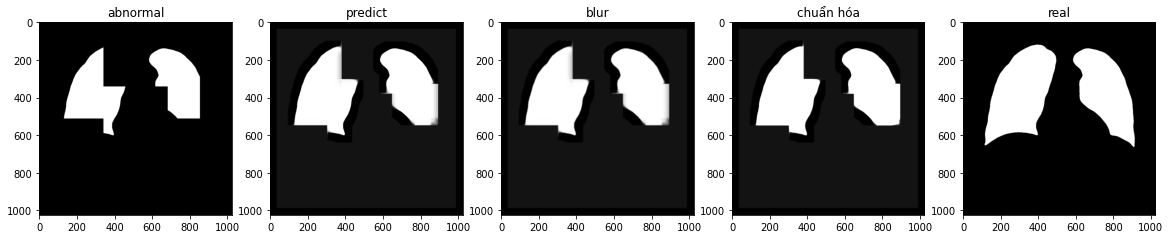

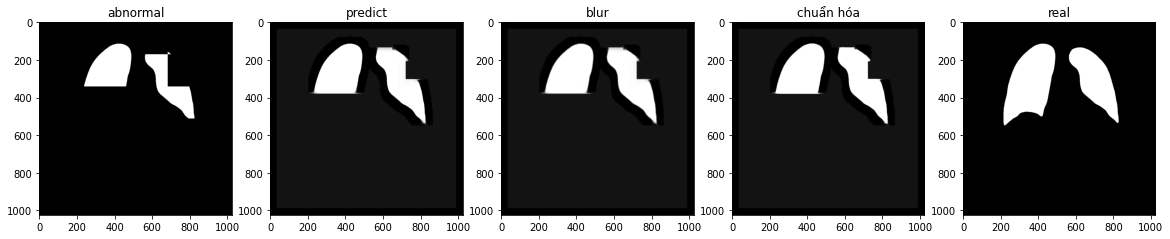

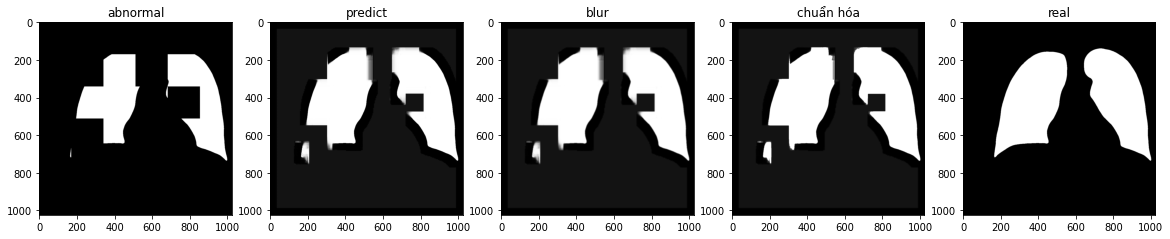

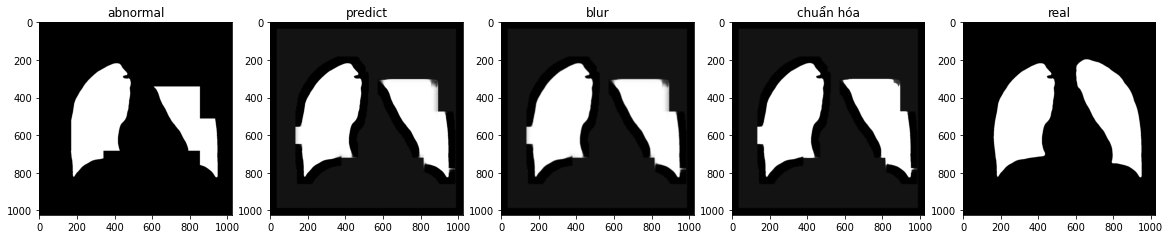

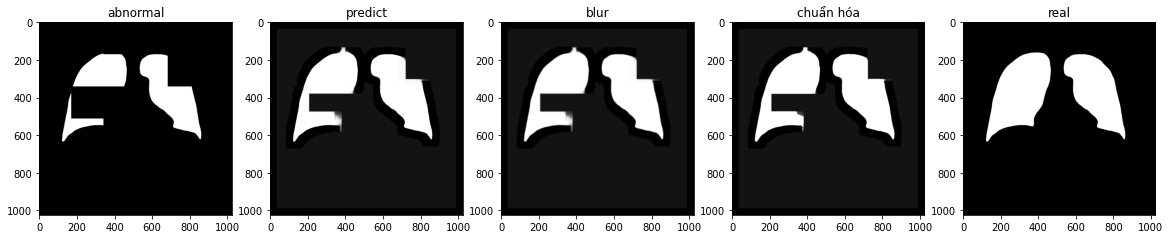

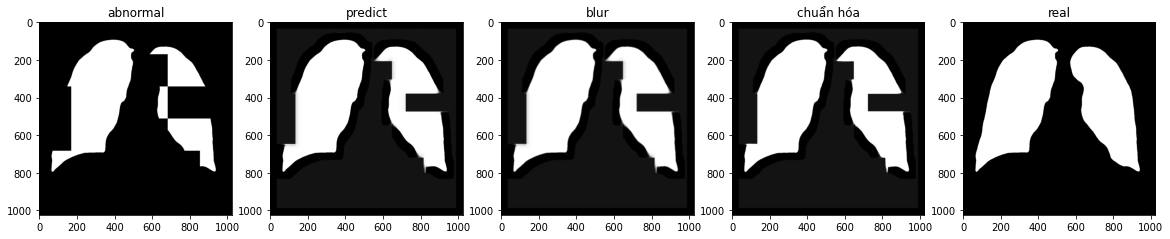

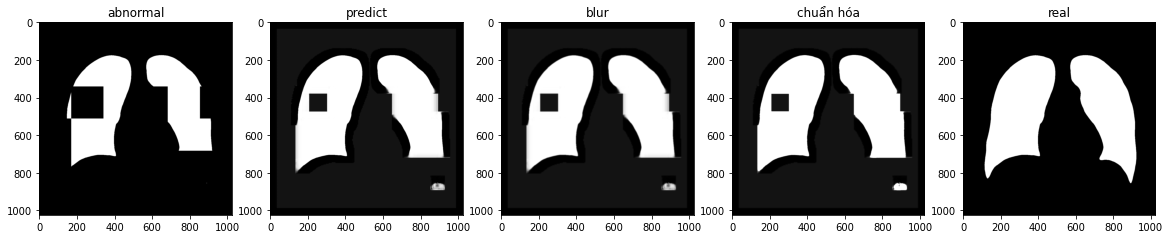

In [ ]:
rows = 1
cols = 5
for i in range(10):
  plt.figure(figsize=(20,10))
  plt.subplot(rows,cols,1)
  plt.imshow(mxtest[i,:,:,0],cmap='gray')
  plt.title('abnormal')
  plt.subplot(rows,cols,2)
  plt.imshow(mxgen[i,:,:,0],cmap='gray')
  plt.title('predict')
  plt.subplot(rows,cols,3)
  mxblur = mxblurs[i].copy()
  plt.imshow(mxblur,cmap='gray')
  plt.title('blur')
  plt.subplot(rows,cols,4)
  # mxblur[mxblur < bmean] = 0
  # mxblur[mxblur >= bmean] = 1
  mxblur[mxblur >= 0.4] = 1
  plt.imshow(mxblur,cmap='gray')
  plt.title('chuẩn hóa')
  plt.subplot(rows,cols,5)
  plt.imshow(mytest[i,:,:,0],cmap='gray')
  plt.title('real')
  plt.show()

#### Predict trên dữ liệu normal

In [ ]:
mygen = autoencoder.predict(mytest,batch_size=5)

In [ ]:
myblurs = np.array([cv2.blur(myg,(5,5)) for myg in mygen])
mytemp = myblurs.copy()
mytemp[mytemp < bmean] = 0
mytemp[mytemp >= bmean] = 1
myscore = pdata.iou_score(mytest[:,:,:,0],mytemp)
print('Score với mask bình thường: ',myscore)

Score với mask bình thường:  0.9989841973187383


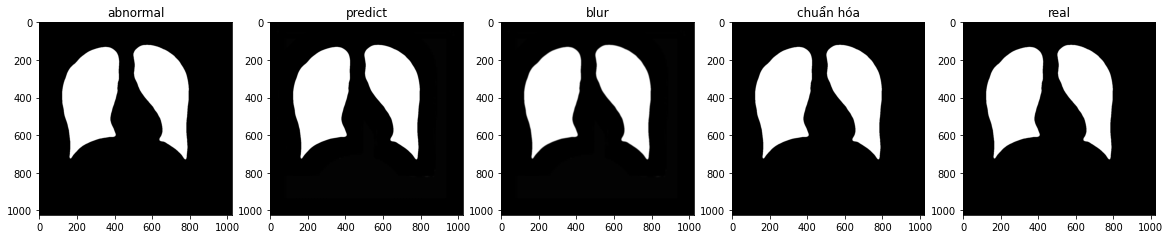

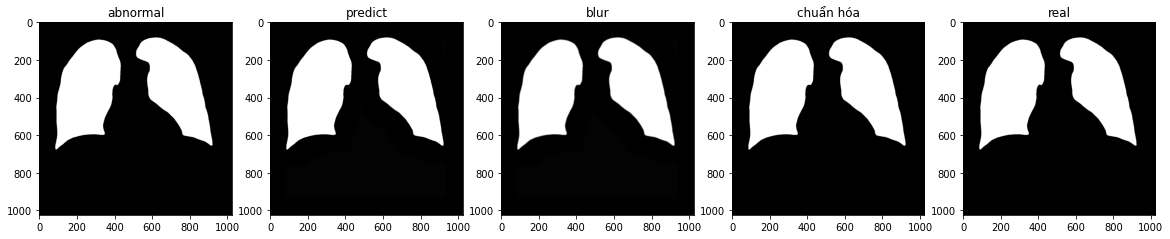

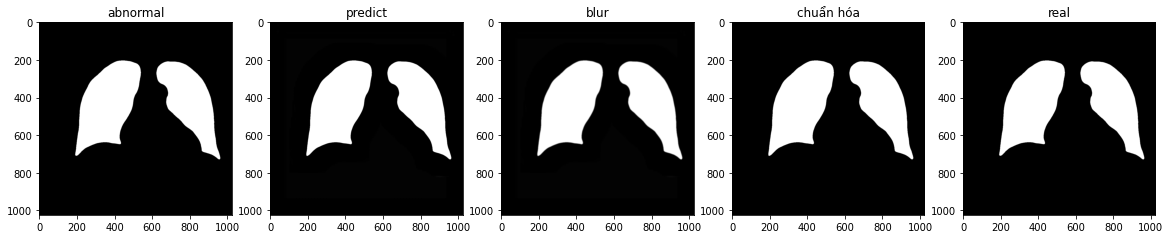

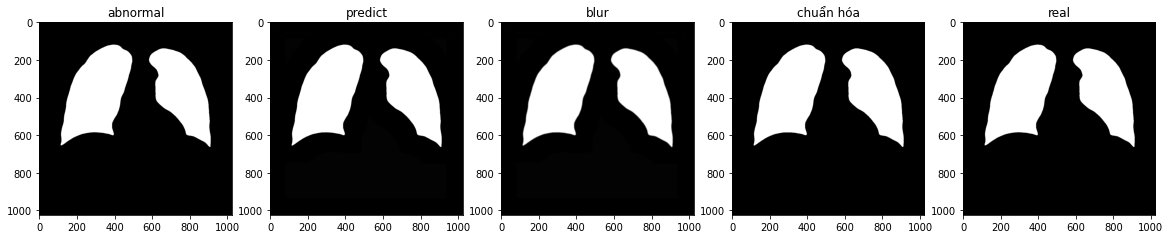

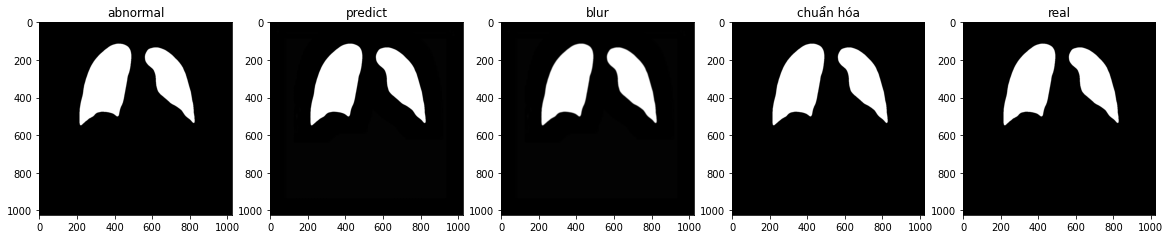

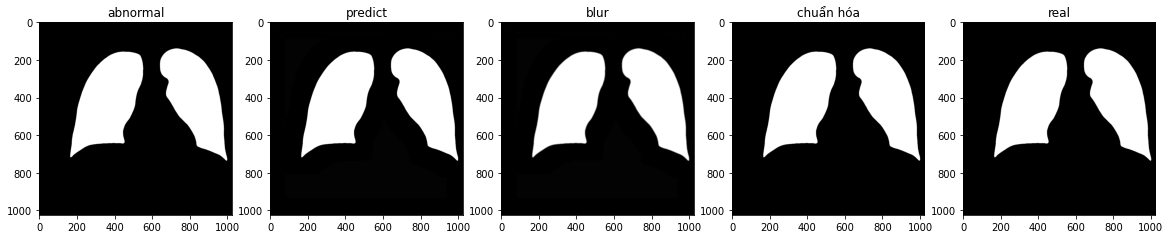

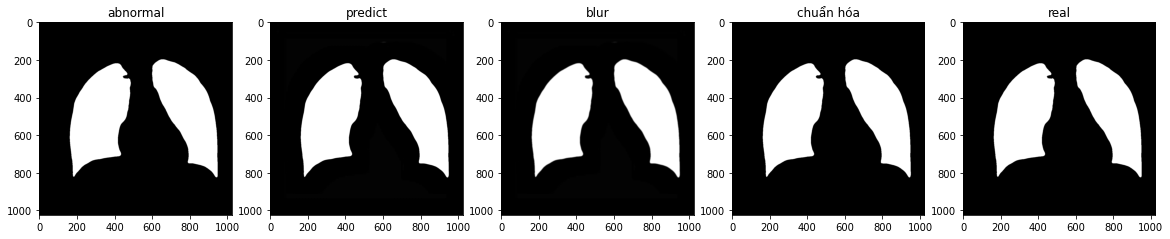

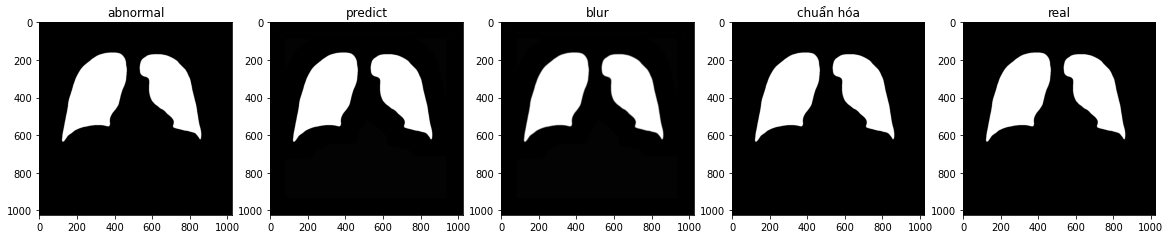

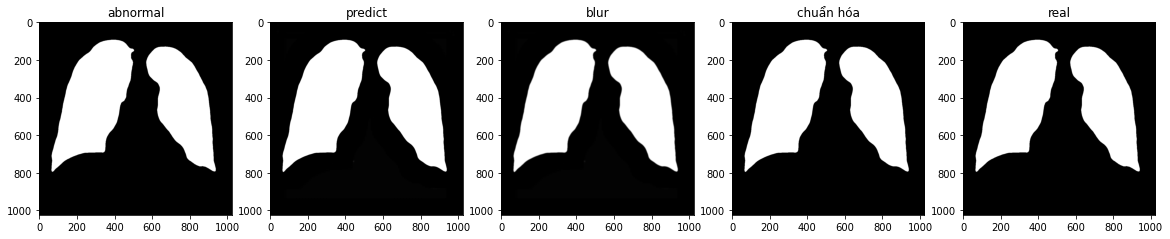

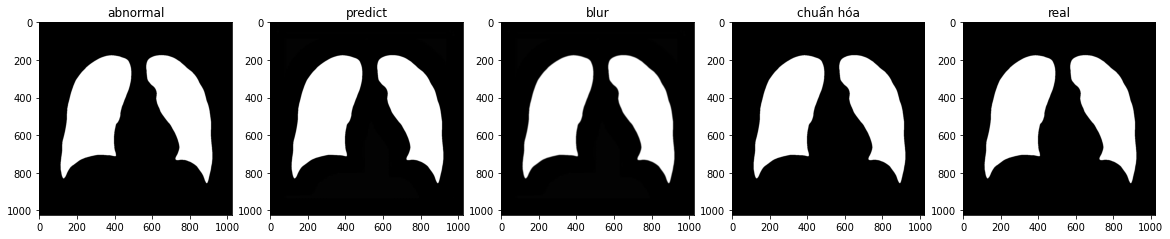

In [ ]:
rows = 1
cols = 5
for i in range(10):
  plt.figure(figsize=(20,10))
  plt.subplot(rows,cols,1)
  plt.imshow(mytest[i,:,:,0],cmap='gray')
  plt.title('abnormal')
  plt.subplot(rows,cols,2)
  plt.imshow(mygen[i,:,:,0],cmap='gray')
  plt.title('predict')
  plt.subplot(rows,cols,3)
  myblur = myblurs[i].copy()
  plt.imshow(myblur,cmap='gray')
  plt.title('blur')
  plt.subplot(rows,cols,4)
  myblur[myblur < bmean] = 0
  myblur[myblur >= bmean] = 1
  plt.imshow(myblur,cmap='gray')
  plt.title('chuẩn hóa')
  plt.subplot(rows,cols,5)
  plt.imshow(mytest[i,:,:,0],cmap='gray')
  plt.title('real')
  plt.show()

### Evaluate autoencoder_mask_d512_f32x64x4_ep100_sigmoid_maxpl

#### Load model

In [14]:
ae_path = './model/checkpoint/autoencoder_mask_d512_f32x64x4_ep100_sigmoid_maxpl/autoencoder_mask_d512_f32x64x4_ep100_sigmoid_maxpl-0043-0.0144.h5'
autoencoder = load_model(ae_path,compile=False)

#### Predict abnormal


In [15]:
mxgen = autoencoder.predict(mxtest,batch_size=5)

(310, 1024, 1024)


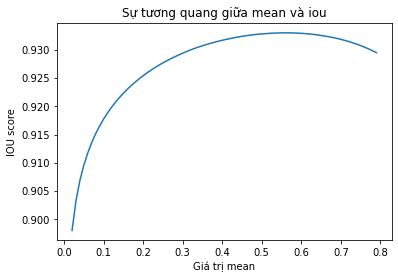

In [16]:
mxmeans = np.arange(0.02,0.8,0.01)
mxblurs = np.array([cv2.blur(mxg,(5,5)) for mxg in mxgen])
print(mxblurs.shape)
scores = []
for mxmean in mxmeans:
  temp = mxblurs.copy()
  temp[temp < mxmean] = 0
  temp[temp >= mxmean] = 1  
  scores.append(pdata.iou_score(mytest[:,:,:,0],temp))
scores = np.array(scores)
plt.plot(mxmeans,scores)
plt.xlabel('Giá trị mean')
plt.ylabel('IOU score')
plt.title('Sự tương quang giữa mean và iou')
plt.show()

In [17]:
df = pd.DataFrame({'mean': mxmeans,'score':scores})
dfpath = ae_path.replace('.h5','_best_mean.csv')
df.to_csv(dfpath)

In [18]:
tindex = scores.argmax()
bmean = mxmeans[tindex]
print('best score: ',scores[tindex])
print('best mean: ',bmean)

best score:  0.9330198103138428
best mean:  0.5599999999999999


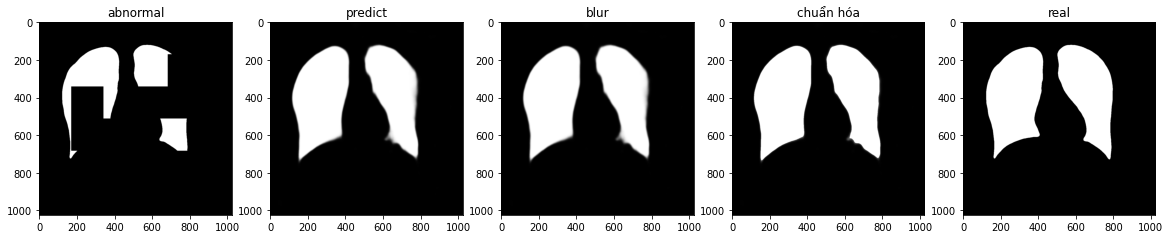

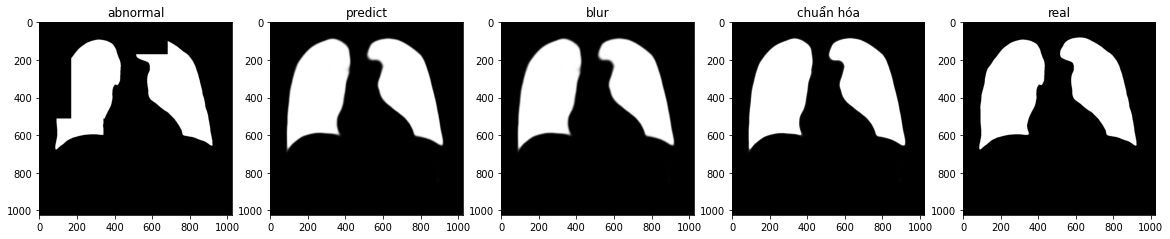

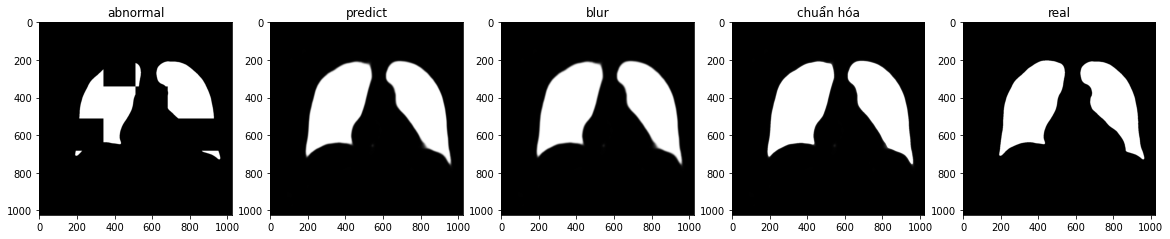

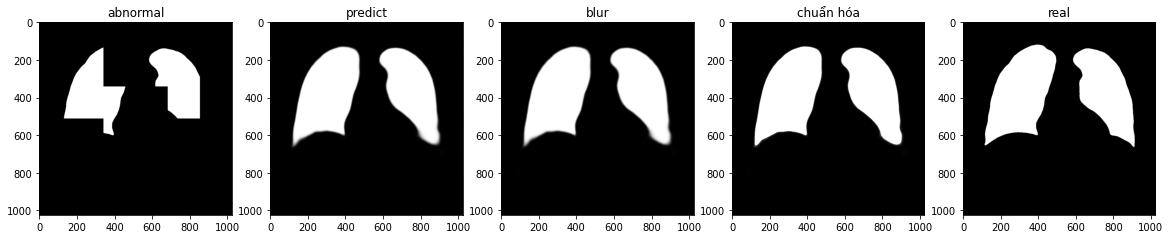

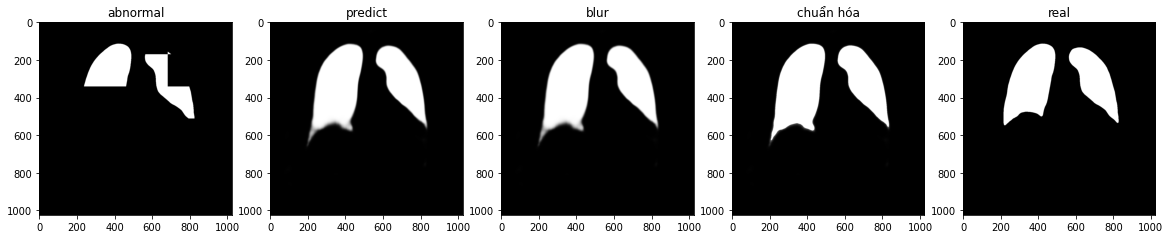

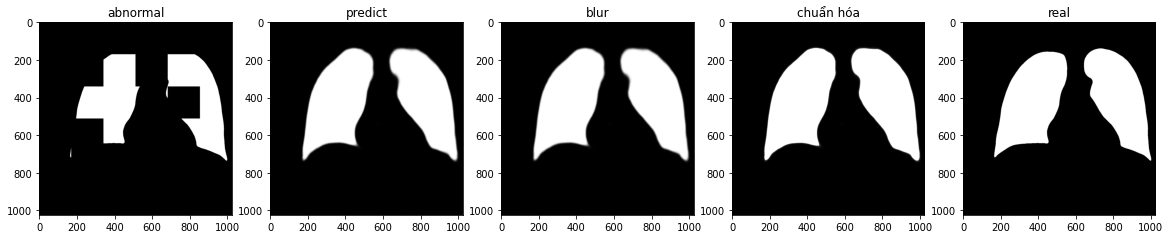

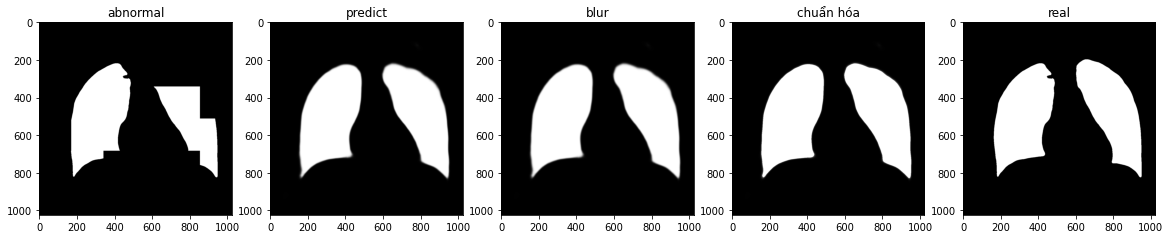

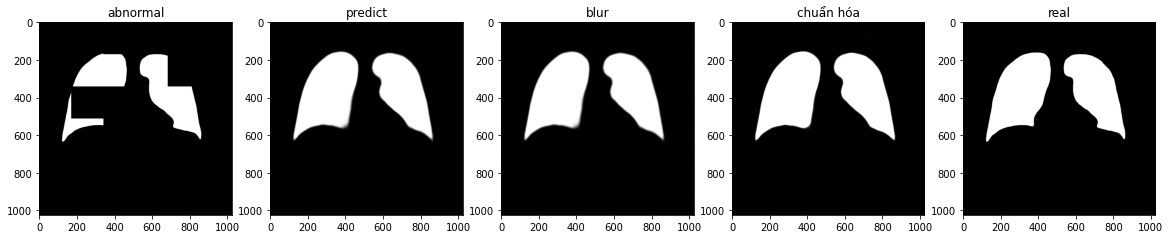

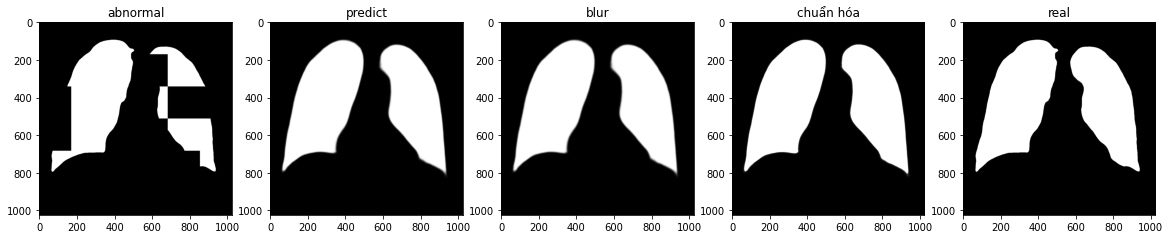

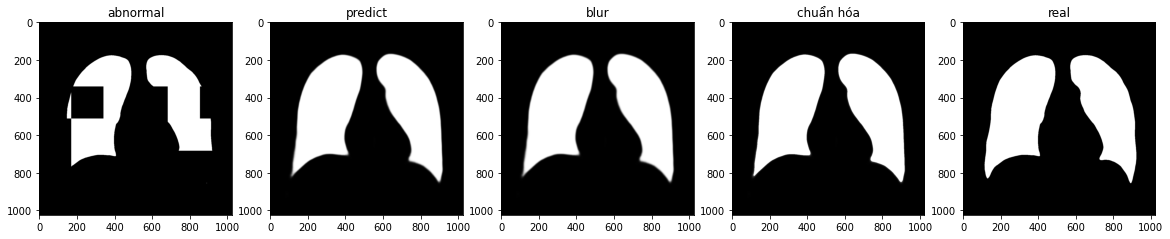

In [19]:
rows = 1
cols = 5
for i in range(10):
  plt.figure(figsize=(20,10))
  plt.subplot(rows,cols,1)
  plt.imshow(mxtest[i,:,:,0],cmap='gray')
  plt.title('abnormal')
  plt.subplot(rows,cols,2)
  plt.imshow(mxgen[i,:,:,0],cmap='gray')
  plt.title('predict')
  plt.subplot(rows,cols,3)
  mxblur = mxblurs[i].copy()
  plt.imshow(mxblur,cmap='gray')
  plt.title('blur')
  plt.subplot(rows,cols,4)
  # mxblur[mxblur < bmean] = 0
  # mxblur[mxblur >= bmean] = 1
  mxblur[mxblur >= 0.4] = 1
  plt.imshow(mxblur,cmap='gray')
  plt.title('chuẩn hóa')
  plt.subplot(rows,cols,5)
  plt.imshow(mytest[i,:,:,0],cmap='gray')
  plt.title('real')
  plt.show()

#### Predict trên dữ liệu normal

In [20]:
mygen = autoencoder.predict(mytest,batch_size=5)

In [21]:
myblurs = np.array([cv2.blur(myg,(5,5)) for myg in mygen])
mytemp = myblurs.copy()
mytemp[mytemp < bmean] = 0
mytemp[mytemp >= bmean] = 1
myscore = pdata.iou_score(mytest[:,:,:,0],mytemp)
print('Score với mask bình thường: ',myscore)

Score với mask bình thường:  0.9524615196891371


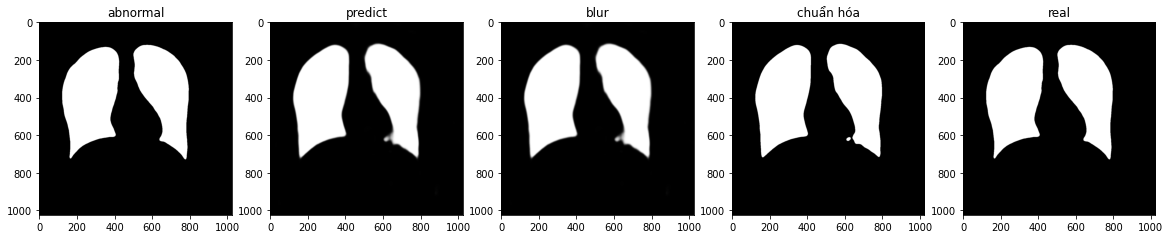

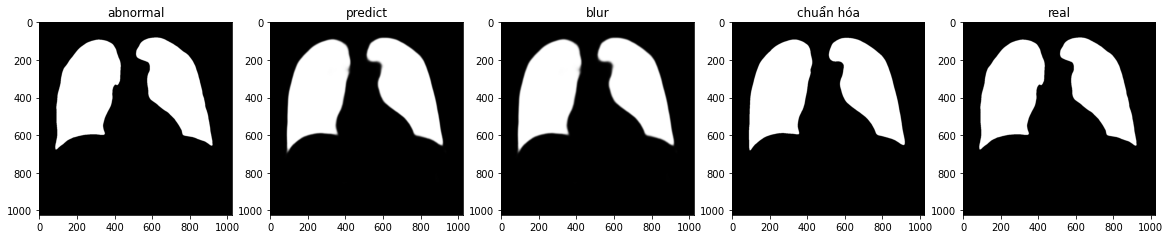

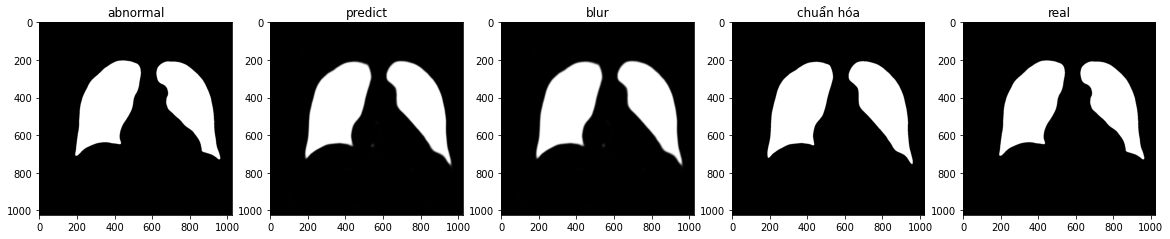

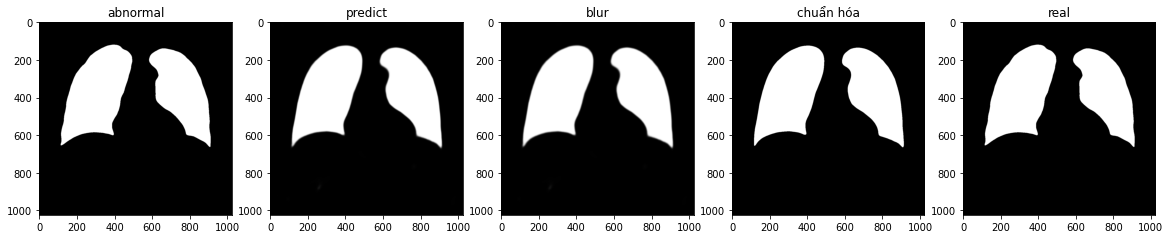

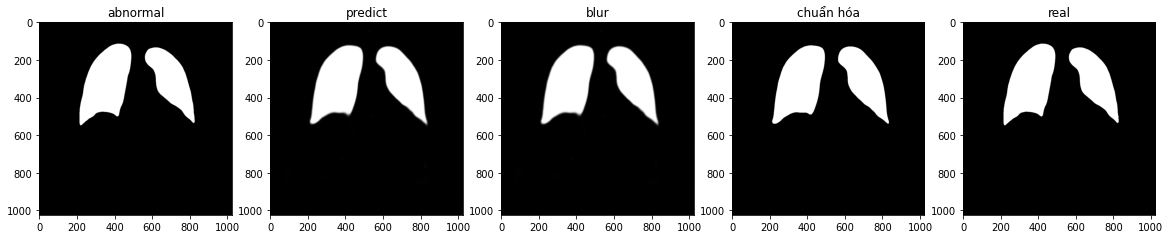

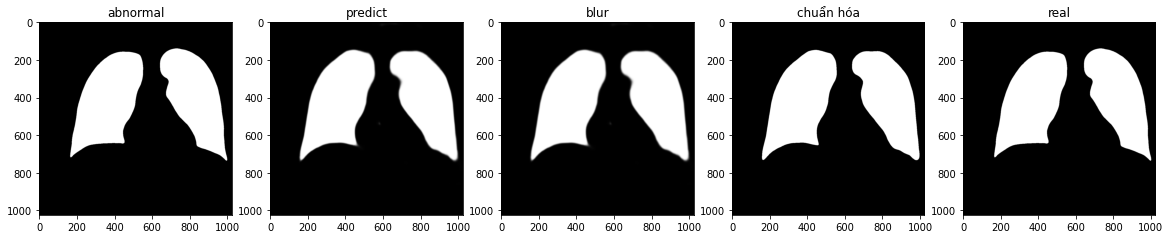

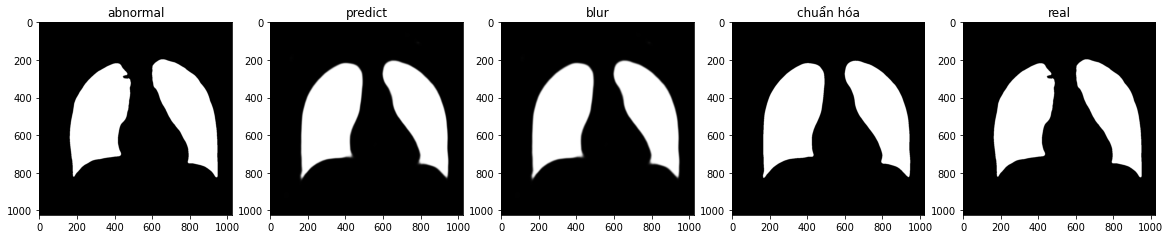

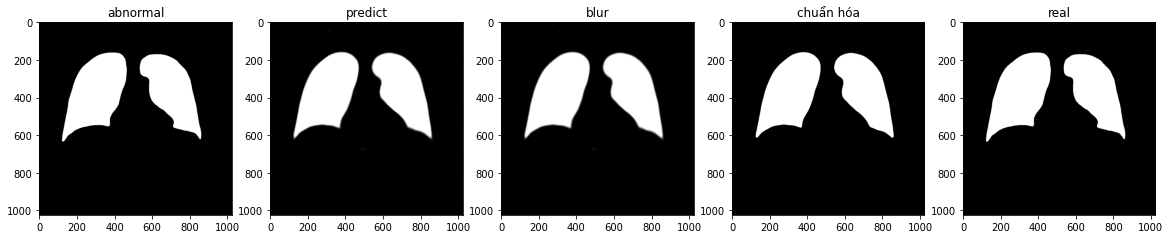

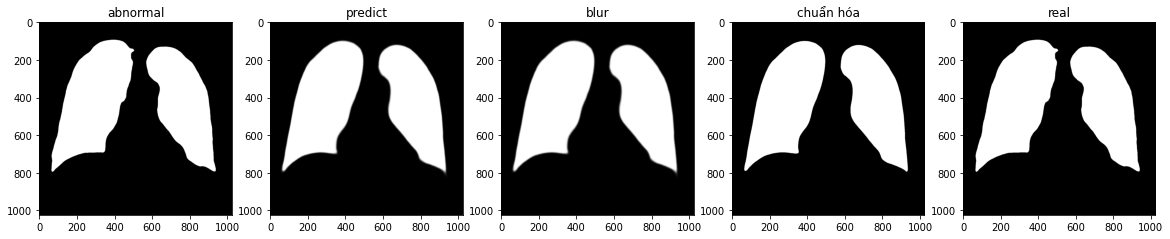

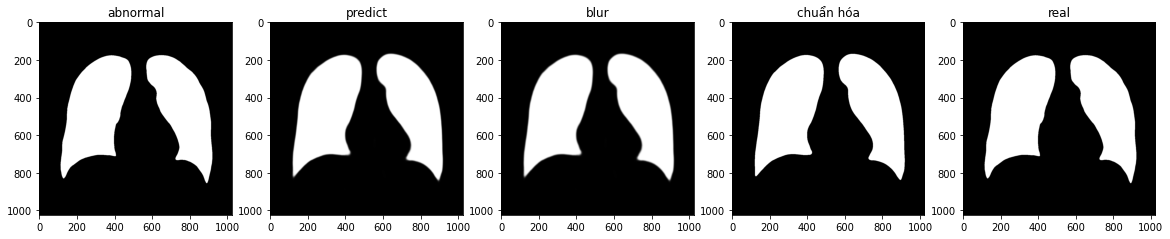

In [22]:
rows = 1
cols = 5
for i in range(10):
  plt.figure(figsize=(20,10))
  plt.subplot(rows,cols,1)
  plt.imshow(mytest[i,:,:,0],cmap='gray')
  plt.title('abnormal')
  plt.subplot(rows,cols,2)
  plt.imshow(mygen[i,:,:,0],cmap='gray')
  plt.title('predict')
  plt.subplot(rows,cols,3)
  myblur = myblurs[i].copy()
  plt.imshow(myblur,cmap='gray')
  plt.title('blur')
  plt.subplot(rows,cols,4)
  myblur[myblur < bmean] = 0
  myblur[myblur >= bmean] = 1
  plt.imshow(myblur,cmap='gray')
  plt.title('chuẩn hóa')
  plt.subplot(rows,cols,5)
  plt.imshow(mytest[i,:,:,0],cmap='gray')
  plt.title('real')
  plt.show()